# Lab 6: Convolutional Network Architectures

BY Yifan Ding

# Business Understanding

## Overview
This dataset is collected from Guangzhou Women and Children’s Medical Center, Guangzhou, and consists of X-ray images of children age 1-5, some of whom had bacterial or viral pneumonia.  The images are x-rays of the chest and have been labeled by two different doctors---with a third the tiebreaker if the two disagreed.  The original images are in different size, so we resized each image to 160x240 pixels jpeg and converted them into grayscale images.  The following graph is from the last page from the Cell Paper: "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" shows the distinction between a normal lung, a lung with bacterial pneumonia, and a lung with viral pneumonia.
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia![image.png](attachment:image.png)

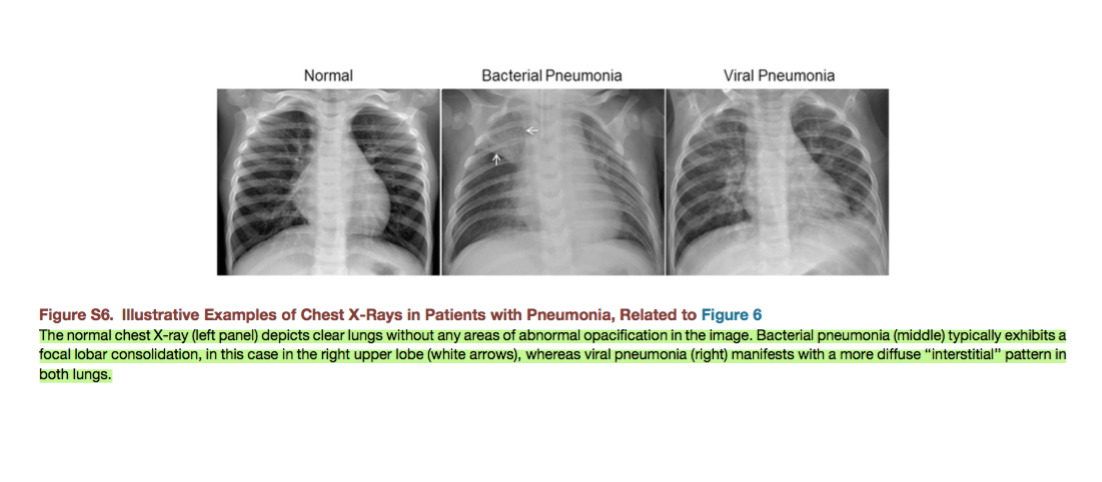

In [1]:
from IPython.display import Image
Image(filename = "/Users/Yifan/Downloads/lessons/7324/lab2/Lung_Classification.png" )

## Purpose
The purpose of this dataset was to develop an artificial neural network that will be able to distinguish between children with pneumonia in order to assist doctors in making the right decision.  There are three different classifications: normal, pneumonia-bacterial, and pneumonia-viral.  The cell paper, "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"'s focus is to use transfer learning which is a technique to train a neural network with a relatively small number of images, (Kermany 1122).  For us, our purpose will be to classify the aforementioned three types for a preliminary screening.  As such, the kids will still receive medial care and a second opinion from a doctor so the stakes are not quite as high for our algorithm.




## Prediction Task
There are three different classifications for our image data. The prediction task for this algorithm is to distinguish between children with a normal lung, a lung with bacterial pneumonia, and a lung with viral pneumonia.  This algorithm would be used by hospitals who have an x-ray machine and who serve children between the ages of 1-5.  Though this data was screened by Chinese children, it can probably be used for children of other nationalities as well.  

## Importance
According to the Cell Paper, data collected by the World Health organization shows that pneumonia kills approximately 2 million children under 5 years old every year (though most of these deaths occur in Southeast asia or Africa). (Kermany 1127)   Since chest x-rays are common and can be used to identify between kids with pneumonia and kids without pneumonia, x-rays were chosen as the method of choice.  If we could develop an accurate and quick classifier, it might be able to be used wherever x-rays are used.  If developed, such an algorithm could be used by nurses and would not require a doctor to analyze the chest x-ray images.  This technique would just save Doctors' time and, potentially, the children who are suffering from pneumonia.  Th algorithm would successfully screen kids with pneumonia and direct them to the needed medical care: antibiotics if the child had bacterial pneumonia, supportive care if the child had viral pneumonia, and discharge if the child does not have pneumonia.


## Desired Accuracy of Classifier

In order for our algorithm to be useful, it would have to be better than the neural net algorithm that has already been created using the same data in some way.  This could mean that our algorithm achieves a greater accuracy than their 93 % and that the area under the ROC curve for our algorithm is better than the area under the ROC curve, (Kermany 1127). The ROC curve is a way to measure the performance of the algorithm by graphing the true positive rate vs. the false positive rate.  The higher to the left the algorithm line is the better the algorithm is. The algorithm in the paper achieved the following ROC curve:   

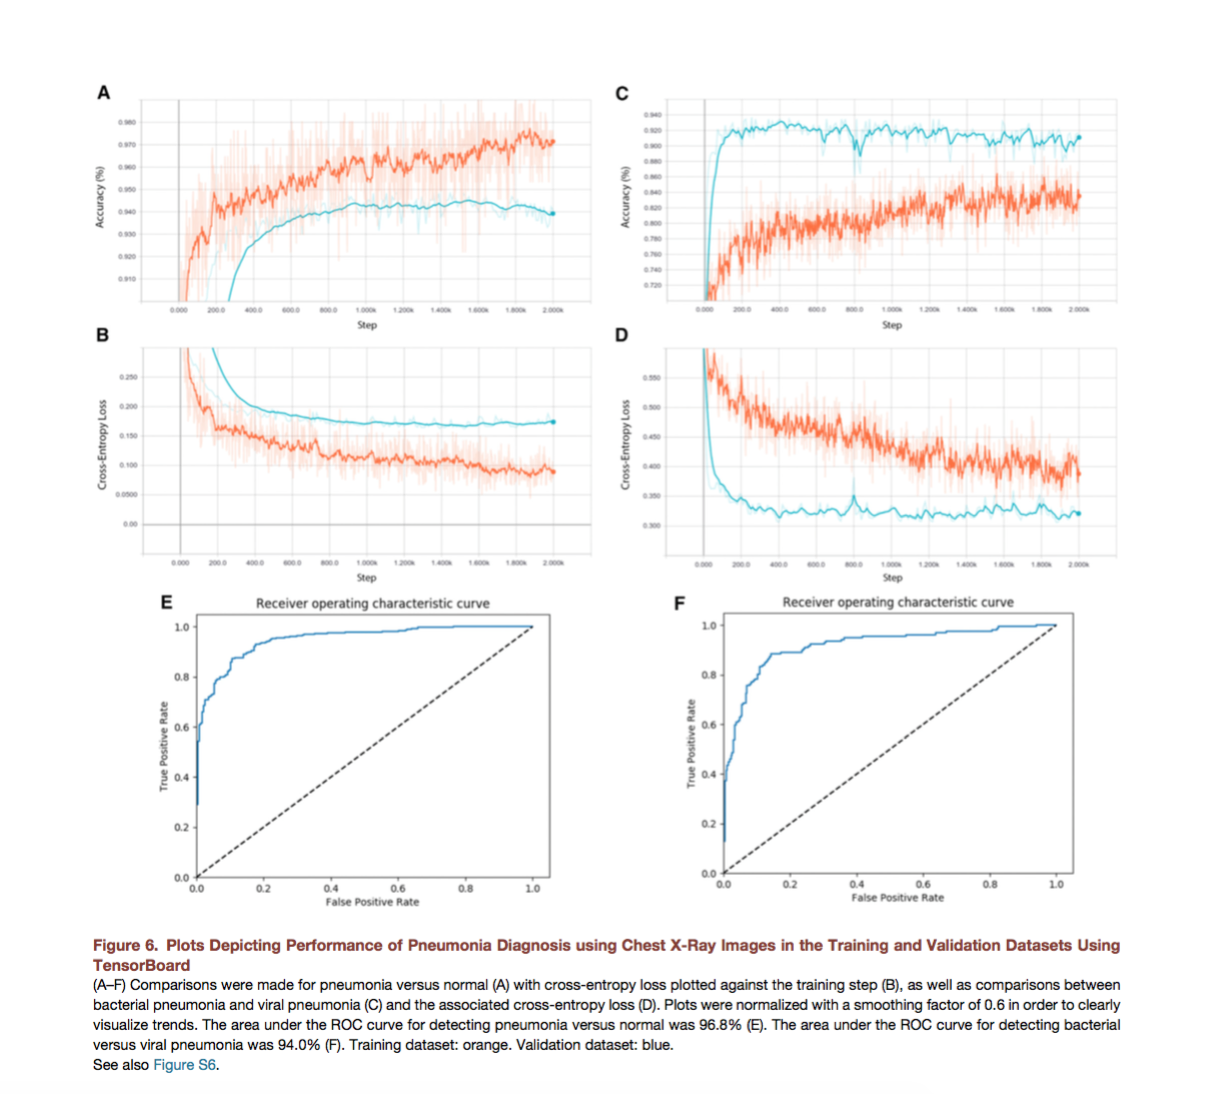

In [129]:
Image(filename = "/Users/Yifan/Downloads/lessons/7324/lab2/ROC_Curve.png" )

## False Positive vs False Negative Trade-off
In all classification problems, it is important to consider which is worse: false positives or false negatives.  In this case, we will define a false positive as when the algorithm predicts that a child has pneumonia even when he or she doesn’t.  A false negative is when the classifier predicts that the child does not have pneumonia even when the child does.  In this case, it is clear that we want to limit the amount of false negatives and instead have more false positives.  If there is a false positive, all that will happen is that the child will go under more supervised care—if the child does not have pneumonia, this will probably be found with time.  If there is a false negative, though, the child will potentially leave the hospital even though he or she has pneumonia. Clearly, we will try to have more false positives than false negatives in this case.

# Citation for Business Understanding

Kermany, D., Goldbaum, M., Cai, W., Valentim, C., Liang, H., Baxter, S., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M., Pei, J., Ting, M., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., Shi, A., Zhang, R., Zheng, L., Hou, R., Shi, W., Fu, X., Duan, Y., Huu, V., Wen, C., Zhang, E., Zhang, C., Li, O., Wang, X., Singer, M., Sun, X., Xu, J., Tafreshi, A., Lewis, M., Xia, H. and Zhang, K. (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, 172(5), pp.1122-1131.e9.

Kaggle Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


# Data Preparation 

## Import required modules

In [260]:
#!pip install opencv-python
# Step 1: Import Modules
import numpy as np
import pandas as pd
import os, sys
import cv2 
from tqdm import tqdm 
import skimage
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import time
import gc
import math

from os import listdir
from glob import glob
import cv2
import seaborn as sns

import keras
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import plotly
plotly.offline.init_notebook_mode()

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

print('Python:', sys.version)
print('Pandas:', pd.__version__)
print('Numpy:', np.__version__)
print('keras:', keras.__version__)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas: 0.24.2
Numpy: 1.16.4
keras: 2.3.1


In [ ]:
w,h=80,120

## Read image data from folder

In [2]:
folder1 = "/Users/yifan/Desktop/train/NORMAL/"
normal = [f for f in os.listdir(folder1) if os.path.isfile(os.path.join(folder1, f))]
folder2 = "/Users/yifan/Desktop/train/PNEUMONIA/"
pneumonia = [f for f in os.listdir(folder2) if os.path.isfile(os.path.join(folder2, f))]
folder = "/Users/yifan/Desktop/train/"
chest = normal + pneumonia
print("Working with {0} images".format(len(chest)))

Working with 5216 images


## Pre-processing images

In [3]:
#Code from https://github.com/deadskull7/Pneumonia-Diagnosis-using-XRays-96-percent-Recall/blob/master/Pneumonia%20Diagnosis%20using%20Lung's%20XRay%20.ipynb

def read_data(folder):
    images = []
    labels = [] #Ture status
    for dirc in os.listdir(folder):
        readin = folder + dirc
        if not dirc.startswith('.'):
            if dirc in ['NORMAL']:
                for image_name in tqdm(os.listdir(readin)):
                    label = 0
                    labels.append(label)
            elif dirc in ['PNEUMONIA']: 
                for image_name in tqdm(os.listdir(readin)):
                    if 'bacteria' in str(image_name):         
                        label = 1
                    elif 'virus' in str(image_name):
                        label = 2
                    labels.append(label)

            for image_name in tqdm(os.listdir(readin)):
                img = cv2.imread(readin + '/' + image_name) #Read in images from folder
                if img is not None:
                    img = skimage.transform.resize(img, (w,h,3)) #Resize each image into 160*240
                    img = np.asarray(img) #Turn each image into array
                    img = ((img/255.)-.5) * 2  #Standardization
                    images.append(img)
                    
            
    images = np.asarray(images) 
    labels = np.asarray(labels)
    
    return images,labels

In [4]:
chest_images, chest_ture = read_data(folder)

100%|██████████| 1341/1341 [11:30<00:00,  2.11it/s]


In [5]:
print(chest_images.shape)
print(chest_ture.shape)

(5216, 80, 120, 3)
(5216,)


In [6]:
print(chest_ture)

[1 1 1 ... 0 0 0]


In [7]:
chest_labels=[]
for label in chest_ture:
    if label == 0:
        chest_labels.append('normal')
    elif label == 1:
        chest_labels.append('bacteria')
    else:
        chest_labels.append('virus')


## Convert to Gray Scale

Luminance is by far more important in distinguishing visual features. An excellent suggestion to illustrate this property would be: take a given image and separate the luminance plane from the chrominance planes. We will use 0.3R+0.59G+0.11*B to convert all the images into gray sclae. Range of grayscale values should spread out between 0 and 255.

In [8]:
def gray_scale(data):
    '''
    input: a np.array of images of rgb format
    output: a np.array of images of grayscale format
    '''
    n_images = data.shape[0]
    n_rows = data.shape[1]
    n_columns = data.shape[2]
    grayscale = np.zeros((n_images, n_rows, n_columns, 1))
    
    for idx in range(n_images):
        grayscale[idx, :, :, 0] = np.add(0.3*data[idx,:,:,0], 0.59*data[idx,:,:,1],
                                        0.2*data[idx,:,:,2])
    return grayscale  

In [9]:
chest_gray = gray_scale(chest_images)

In [10]:
print(chest_gray.shape)

(5216, 80, 120, 1)


## Linearize the Data

In [11]:
def linearize(data):
    '''
    input:a np.array of images
    output: a 2-D np.array(1-D image feature for each row)
    '''
    num_images = data.shape[0]
    num_columns = int(np.prod(data.shape)/num_images)
    
    linear = np.zeros((num_images, num_columns))
    linear = np.reshape(data, (num_images, num_columns))
    return linear

chest_gray_linear = linearize(chest_gray)
chest_rgb_linear = linearize(chest_images)

In [12]:
print(chest_gray_linear.shape)

(5216, 9600)


## Images examples

We displayed some images from three groups.

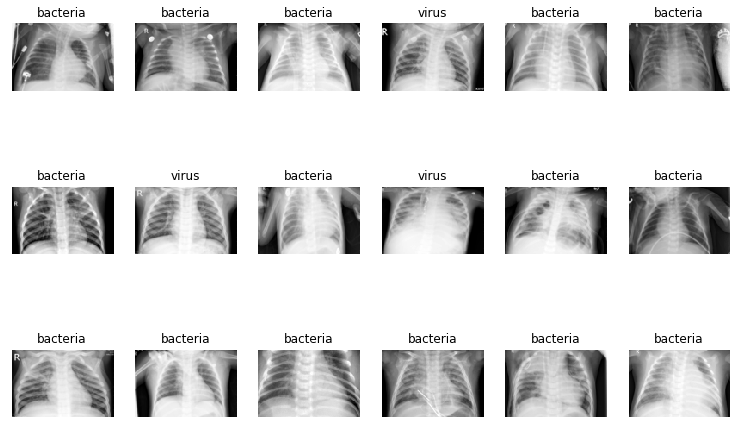

In [13]:
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h,w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(chest_gray, chest_labels,w,h)

From the images of normal chest and pneumonia, we can hardly tell the differences between them just by insight. It indicates that further analysis of images is essential for this case.

In [14]:
i=0
j=0
k=0
for label in chest_ture:
    if label == 1:
        i=i+1
    elif label == 2:
        j=j+1
    else:
        k=k+1
print('bacteria:',i,
      'virus:',j,
     'normal:',k)


bacteria: 2530 virus: 1345 normal: 1341


# Description of Final Dataset
Each column in dataset represents a specific pixel, each row represents one image,which is total 5216 images. A value in dataset represents the darkness or grayscale of the image. Our target is 3 classes outuput, normal, bacteria and virus.

# Data Reduction

# Principal Component Analysis (PCA)

## PCA Equations

Raschka, S. and Mirjalili, V. (n.d.). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. 2nd ed. Packt Publishing.

### Feature Reduction:

$$x = \begin{bmatrix}
x_{1} & x_{2} & ... & x_{d}
\end{bmatrix}, x \,  \epsilon \,  \mathbb{R}^{d}$$

$$\downarrow xW, W\epsilon \, \mathbb{R}^{dxk}$$

$$z = \begin{bmatrix}
z_{1} &z_{2}  & ... & z_{k}
\end{bmatrix}, z\, \epsilon \, \mathbb{R}^{k}$$



### Creating the Covariance Matrix (pg 145-pg 146 in Raschka)
$$\sigma _{jk} = \frac{1}{n}\sum_{i = 1}^{n} (x^{(i)}_{j} -\mu _{j})(x_{k}^{(i)} -\mu _{k})$$


$$ \sum = \begin{bmatrix}
\sigma ^{2}_{1} & \sigma _{12} & \sigma _{13} \\ 
 \sigma _{21}& \sigma ^{2}_{2} & \sigma _{23}\\ 
 \sigma _{31}& \sigma _{32} & \sigma ^{2}_{3}
\end{bmatrix} $$

### Find Eigenvalues (pg 146 in Raschka)

$$\varepsilon  v = \lambda v$$

### Total and Explained Variance (pg 147 in Raschka)

$$\frac{\lambda _{j}}{\sum_{j=1}^{d} \lambda _{j}}$$



### Projecting onto new Feature Space (page 162 in Raschka)

$$X^{'} = XW$$

In [15]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

In [16]:
def full_pca(data,n):
    '''
    input:data,n_components
    output: full pca of data
    '''
    chest_pca = PCA(n_components=n)
    return chest_pca.fit(chest_gray_linear)

In [17]:
chest_pca = full_pca(chest_gray_linear,5216)

# Plot individual and cumulative explained variance

In [25]:
def explain_variance(pca):
    '''
    input:pca 
    output: explained variance
    '''
    explained_var = pca.explained_variance_ratio_
    return explained_var

In [20]:
def cumu_variance(pca):
    '''
    input:pca 
    output: cumulative variance
    '''
    cumu_var_exp = np.cumsum(pca.explained_variance_ratio_)
    return cumu_var_exp

In [21]:
cumu_var = cumu_variance(chest_pca)
explained_var = explain_variance(chest_pca)
print(cumu_var)
print(explained_var)

[0.25632606 0.36139141 0.43453036 ... 1.         1.         1.        ]
[2.56326056e-01 1.05065359e-01 7.31389425e-02 ... 2.46829023e-37
 2.46299002e-37 4.40894729e-38]


In [22]:
#!pip install cufflinks plotly

In [23]:
#The plot_explained_variance function is adapted from Eric's 04. Dimension Reduction and Images

from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
import plotly 
def plot_explained_variance(var1,var2):  
    plotly.offline.iplot({
    "data": [Scatter(y=var1, name='Explained variance'),
             Scatter(y=var2, name='cumulative explained variance')
        ],
    "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

# PCA with first 200 components

In [330]:
chest_pca_first200 = full_pca(chest_gray_linear,200)

# Reshape with first 200 components

In [338]:
eigen_chest = chest_pca_first200.components_.reshape(200,w,h)

In [339]:
eigen_chest.shape

(200, 80, 120)

In [340]:
#The plot_gallery function is from Eric's 04. Dimension Reduction and Images

import matplotlib.pyplot as plt# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=4, n_col=6):
    """
    input:  image matrix
    output: image gallery 
    """
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

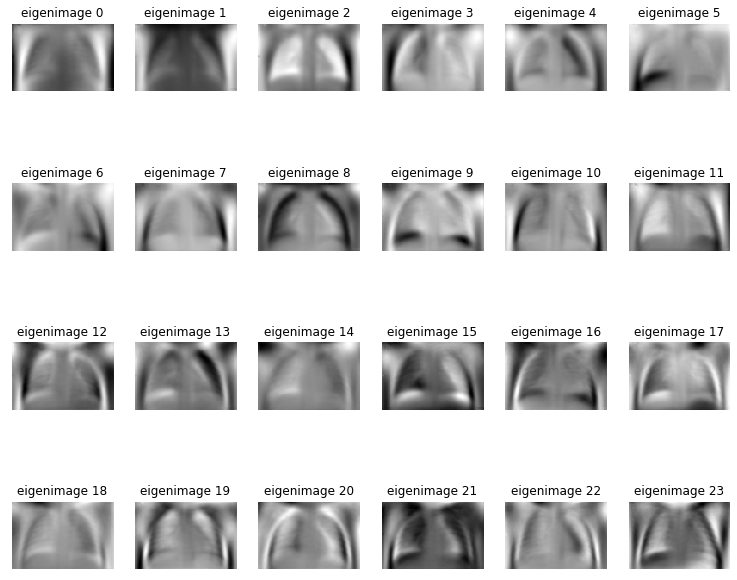

In [341]:
eigenlabels = ['eigenimage ' + str(i) for i in range(eigen_chest.shape[0])]
plot_gallery(eigen_chest,eigenlabels,w,h)

The components represent our images well. The first component reflect the average of the 5216 images

# Compare Original with PCA

In [31]:
#Reconstruct_image function is adapated from Eric's 04 Dimensional Reduction and Images
''' original from Eric
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 131    
chest_gray_linear_idx = chest_gray_linear[idx_to_reconstruct]
low_dim, reconstructed_image = reconstruct_image(chest_pca_first200,chest_gray_linear_idx.reshape(1, -1))
'''
def reconstruct_image(trans_obj,pca_features,idx):
    '''
    input:pca_data,trans_obj,org_features,idx
    output:tranformation of the specific picture
    '''
    low_dim = trans_obj.transform(pca_features[idx].reshape(1,-1))
    rec_image = trans_obj.inverse_transform(low_dim)
    return low_dim, rec_image

In [32]:
chest_gray_linear.shape

(5216, 38400)

In [342]:
chest_pca_first200.components_.shape

(200, 9600)

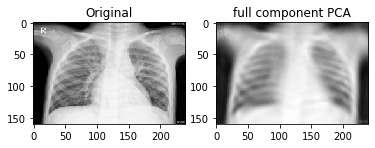

In [34]:
#Make a comparison here
#Take the 100th image as an example
low_dim, rec_image = reconstruct_image(chest_pca_first200,chest_gray_linear,100)

plt.subplot(1,2,1)
plt.imshow(chest_gray_linear[100].reshape(160,240), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)

plt.subplot(1,2,2)
plt.imshow(rec_image.reshape(160,240), cmap=plt.cm.gray)
plt.title('full component PCA')
plt.grid(False)

As a check on our code, we tried to calculate Radial Based PCA as a negative case to see whether it is the worst one among those PCA methods.  From the image analysis, we expect it to be the worst.  Thankfully, it only has an accuracy of 72%.

# New for lab6

So comparing PCA and Kernal PCA with the first 200 components, it is clear that the PCA and polynomial PCA 
do the best with more than 95% accuracy, while the Radial Based PCA does the worst, with only 75% accuarcy.

Above all, we would use the full PCA with first 200 components to be the final dataset that is used for classification.

# Split train and test data set

## Use Stratified 10-fold to separate train and test set

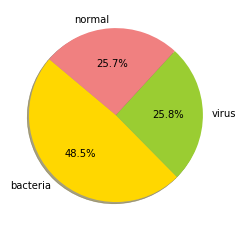

In [28]:
# Data to plot
labels = 'bacteria','virus','normal'
sizes = [2530,1345,1341]
colors = ['gold', 'yellowgreen', 'lightcoral']

# Plot
plt.pie(sizes,labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.show()

As you can see above, we have 1341 samples that are normal, 2530 samples that are pneumonia-bacteria and 1345 samples that are pneumonia-viral, the proportion are quite different for three classes. So we want to keep the same proportion of different classes in each fold to make sure that each fold is a good representative of the whole data. Another problem we have to pay attention to is our sample size. From the counts of three categories, the sample size for normal and pneumonia-viral is small. After we do a 80/20 split for train and test set, we only have 1341/5=268 samples of normal in the test set. It is not enough, and we can get almost any performance on this set only due to chance. In K Fold cross validation, the data is divided into k subsets. 

Now the holdout method is repeated k times, such that each time, one of the k subsets is used as the test set/ validation set and the other k-1 subsets are put together to form a training set. The error estimation is averaged over all k trials to get total effectiveness of our model. As can be seen, every data point gets to be in a validation set exactly once, and gets to be in a training set k-1 times. This significantly reduces bias as we are using most of the data for fitting, and also significantly reduces variance as most of the data is also being used in validation set. As a general rule and empirical evidence, K = 5 or 10 is generally preferred as it is often reported that the optimal k is between 5 and 10 , because the statistical performance does not increase a lot for larger values of k. So for our problem, using a 5/10 fold cross validation method to do an 80/20 split is a better way. Since we also want the same proportion of different classes in each fold, Stratified 10-fold is a better choice.

## Reference
Arlot, Sylvain, and Alain Celisse. “A Survey of Cross-Validation Procedures for Model Selection.” Statistics Surveys, The Author, under a Creative Commons Attribution License, https://projecteuclid.org/download/pdfview_1/euclid.ssu/1268143839.

Gupta, Prashant. “Cross-Validation in Machine Learning.” Medium, Towards Data Science, 5 June 2017, https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f.

Shulga, Dima. “5 Reasons Why You Should Use Cross-Validation in Your Data Science Projects.” Medium, Towards Data Science, 27 Sept. 2018, https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79.

# Use sklearn StratifiedKFold to implement

We use our method to evaluate the metric by 10-fold Stratified Cross Validation.

In [407]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn import metrics

chest_skf=StratifiedKFold(n_splits=10)
X_train = []
X_test = []
y_train = []
y_test = []

for train_index,test_index in chest_skf.split(chest_gray_linear,chest_ture):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train_temp, X_test_temp =chest_gray_linear[train_index],chest_gray_linear[test_index]
    y_train_temp ,y_test_temp =chest_ture[train_index],chest_ture[test_index]
    
    X_train.append(X_train_temp)
    X_test.append(X_test_temp)
    y_train.append(y_train_temp)
    y_test.append(y_test_temp)


Train Index: [ 373  378  381 ... 5213 5214 5215] ,Test Index: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184

In [408]:
# scale the numeric, continuous variables
from sklearn.preprocessing import StandardScaler
for i in range(10):
    ss = StandardScaler()
    X_train[i] = ss.fit_transform(X_train[i])
    X_test[i] = ss.transform(X_test[i])

In [409]:
print(X_train[0])

[[-0.67193352 -0.70305958 -0.6893315  ... -0.3521171  -0.32570586
  -0.28708402]
 [ 0.18288938  0.45014579  0.72850566 ... -0.60914556 -0.58795899
  -0.56338469]
 [-0.96624897 -1.04754902 -1.13095292 ... -0.60914556 -0.55517735
  -0.2952707 ]
 ...
 [ 0.19078991  0.2975301   0.39793525 ... -0.60914556 -0.58795899
  -0.56338469]
 [-0.96624897 -1.04754902 -1.13095292 ... -0.60914556 -0.58795899
  -0.56338469]
 [ 1.75414457  0.45750667 -0.01527777 ... -0.60914556 -0.58795899
  -0.56338469]]


## Use pca with first 200 components

In [410]:
train_pca_200=[]
test_pca_200=[]
for i in range(10):
    train_temp = full_pca(X_train[i],200)
    eigen_temp = train_temp.components_
    eigen_temp = np.transpose(eigen_temp)
    train_temp = X_train[i] @ eigen_temp
    test_temp = X_test[i] @ eigen_temp
    train_pca_200.append(train_temp)
    test_pca_200.append(test_temp)

In [411]:
for i in range(10):
    print(i+1,train_pca_200[i].shape,test_pca_200[i].shape)

1 (4693, 200) (523, 200)
2 (4694, 200) (522, 200)
3 (4694, 200) (522, 200)
4 (4694, 200) (522, 200)
5 (4694, 200) (522, 200)
6 (4695, 200) (521, 200)
7 (4695, 200) (521, 200)
8 (4695, 200) (521, 200)
9 (4695, 200) (521, 200)
10 (4695, 200) (521, 200)


In [412]:
CLASSES = 3
y_train_ohe=[]
y_test_ohe=[]
for i in range(10):
    y_train[i]=np.array(y_train[i])
    y_test[i]=np.array(y_test[i])
    y_train_temp = keras.utils.to_categorical(y_train[i], CLASSES)
    y_test_temp = keras.utils.to_categorical(y_test[i], CLASSES)
    y_train_ohe.append(y_train_temp)
    y_test_ohe.append(y_test_temp)

# Evaluate metric

## Metrics measurement

As we mentioned in False Positive vs False Negative Trade-off, in all classification problems, it is important to consider which is worse: false positives or false negatives. In this case, we will define a false positive as when the algorithm predicts that a child has pneumonia even when he or she doesn’t. A false negative is when the classivier predicts that the child does not have pneumonia even when the child does. In this case, it is clear that we want to limit the amount of false negatives. We also want to keep children from unnessary treatment, which will happen in false positive situation.

Since higher recall ratio illustrates lower false negative and we also concer about lower false positive, we should use **F1-score** as our main metric. F1-score are defined for binary classes. There are two ways to combine it into multiple classes. **micro** is calculated for the individual TPs, TNs, FPs, FNs of the confusion matrix, which weights each instance equally. **macro** is calculated as the average scores of the confusion matrix, which weights each class equally to evaluate the overall performance. Since we have an imbalanced instance for each class, we perfer to use F1 weighted macro-average score.

Given the metric for $K^{th}$ classes $X_k$:
$$F1_{micro} = \frac {2\times (TP_1 + ... + TP_k) } {2\times (TP1_1 +  ... + TP_k) + FP_1 +  ... + FP_k + FN_1 + ... + FN_k} $$

$$F1_{macro} = \frac {X_1  + ... + X_k} {k} $$

# Add f1_score

## Reference
Guglielmocamporese. “Macro F1-Score Keras.” Kaggle, Kaggle, 20 Oct. 2018, https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras.


In [413]:
# modified by https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import keras.backend as K
import tensorflow as tf
from tensorflow import math

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# 3. Modeling

## Reference: 
Class notebooks: https://github.com/eclarson/MachineLearningNotebooks</li>

## Define MLP model from sklearn

In [414]:
# make a keras MLP
for i in range(10):
    print('fold: '+ str(i+1))
    mlp = Sequential()
    mlp.add( Dense(input_dim=train_pca_200[i].shape[1], units=100, activation='relu') )
    mlp.add( Dense(units=50, activation='relu') )
    mlp.add( Dense(units=50, activation='relu') )
    mlp.add( Dense(CLASSES) )
    mlp.add( Activation('softmax') )

    mlp.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy',f1])

    mlp_simple = mlp.fit(train_pca_200[i], y_train_ohe[i], 
            batch_size=32, epochs=10, 
            shuffle=True, verbose=1,validation_data=(test_pca_200[i],y_test_ohe[i]))


fold: 1
Train on 4693 samples, validate on 523 samples
Epoch 1/10
4693/4693 [==============================] - 1s 126us/step - loss: 0.8252 - accuracy: 0.6972 - f1: 0.6528 - val_loss: 0.6154 - val_accuracy: 0.7304 - val_f1: 0.4052
Epoch 2/10
4693/4693 [==============================] - 0s 39us/step - loss: 0.4644 - accuracy: 0.8050 - f1: 0.7766 - val_loss: 0.6185 - val_accuracy: 0.7342 - val_f1: 0.3836
Epoch 3/10
4693/4693 [==============================] - 0s 39us/step - loss: 0.3450 - accuracy: 0.8511 - f1: 0.8361 - val_loss: 0.5896 - val_accuracy: 0.7495 - val_f1: 0.4132
Epoch 4/10
4693/4693 [==============================] - 0s 39us/step - loss: 0.2606 - accuracy: 0.9016 - f1: 0.8959 - val_loss: 0.6457 - val_accuracy: 0.7725 - val_f1: 0.4313
Epoch 5/10
4693/4693 [==============================] - 0s 34us/step - loss: 0.1929 - accuracy: 0.9248 - f1: 0.9190 - val_loss: 0.6201 - val_accuracy: 0.7763 - val_f1: 0.4307
Epoch 6/10
4693/4693 [==============================] - 0s 32us/step 

In [416]:
epochs = 10
w,h=10,20 #Reshape to 10*20
input_shape = (w, h, 1)

# Data Expansion

Feature Standardization is not needed here since we have normalized our data already. ZCA Whitening is not necessary as well because we are using PCA. We keep random rorations to train our model to better handle images. Random shifts might not make any differences in our case. Also, we keep random flips to improve performance since we believe our images can be fliped. Random shifts might not make any differences in our case. 

## Reference

Brownlee, Jason. “Image Augmentation for Deep Learning With Keras.” Machine Learning Mastery, 12 Sept. 2019, https://machinelearningmastery.com/image-augmentation-deep-learning-keras/.

# First simple CNN

In [417]:
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import f1_score

In [418]:
mlp = Sequential()
mlp.add( Dense(input_dim=train_pca_200[i].shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1])

In [419]:
# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add( Reshape((1,w,h), input_shape=(1,w*h)) ) 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,w,h),
               data_format="channels_first") )
cnn.add( Activation('relu') )
cnn.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

cnn.compile(loss='mean_squared_error',
      optimizer='rmsprop',
      metrics=['accuracy',f1])


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 1, 10, 20)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 10, 20)        80        
_________________________________________________________________
activation_107 (Activation)  (None, 16, 10, 20)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 5, 10)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_294 (Dense)            (None, 3)                 2403      
_________________________________________________________________
activation_108 (Activation)  (None, 3)               

In [420]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        f1_cnn = mt.f1_score(y_test,yhat_cnn,average='macro') #Using f1 score
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(f1_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        f1_mlp = mt.f1_score(y_test,yhat_mlp,average='macro') #Using f1 score
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(f1_mlp))

In [427]:
def contingency_column(cnn, X_test, y_test):
    yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
    return [yhat_cnn[i] == y_test[i] for i in range(len(y_test))]

In [428]:
def contingency_column_mlp(cnn, X_test, y_test):
    yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
    return [yhat_mlp[i] == y_test[i] for i in range(len(y_test))]

Fold:1
MLP
Train on 4693 samples, validate on 523 samples
Epoch 1/10
4693/4693 [==============================] - 0s 38us/step - loss: 0.0318 - accuracy: 0.9923 - f1: 0.9922 - val_loss: 1.1940 - val_accuracy: 0.7820 - val_f1: 0.4443
Epoch 2/10
4693/4693 [==============================] - 0s 35us/step - loss: 0.0331 - accuracy: 0.9900 - f1: 0.9890 - val_loss: 1.1856 - val_accuracy: 0.8011 - val_f1: 0.4521
Epoch 3/10
4693/4693 [==============================] - 0s 31us/step - loss: 0.0225 - accuracy: 0.9921 - f1: 0.9913 - val_loss: 1.2782 - val_accuracy: 0.7878 - val_f1: 0.4428
Epoch 4/10
4693/4693 [==============================] - 0s 32us/step - loss: 0.0175 - accuracy: 0.9947 - f1: 0.9945 - val_loss: 1.3695 - val_accuracy: 0.7973 - val_f1: 0.4537
Epoch 5/10
4693/4693 [==============================] - 0s 38us/step - loss: 0.0160 - accuracy: 0.9940 - f1: 0.9938 - val_loss: 1.3953 - val_accuracy: 0.7839 - val_f1: 0.4435
Epoch 6/10
4693/4693 [==============================] - 0s 32us/ste

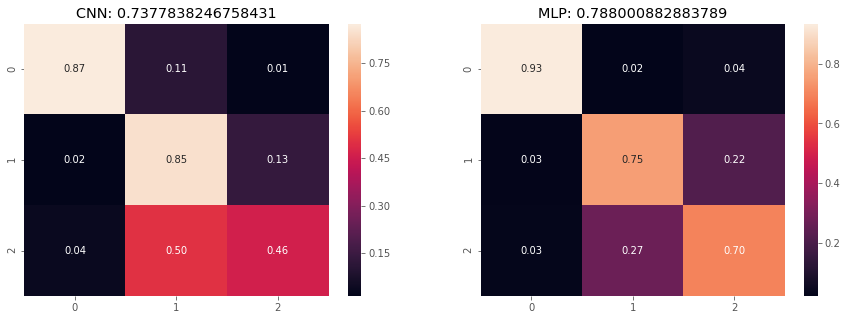

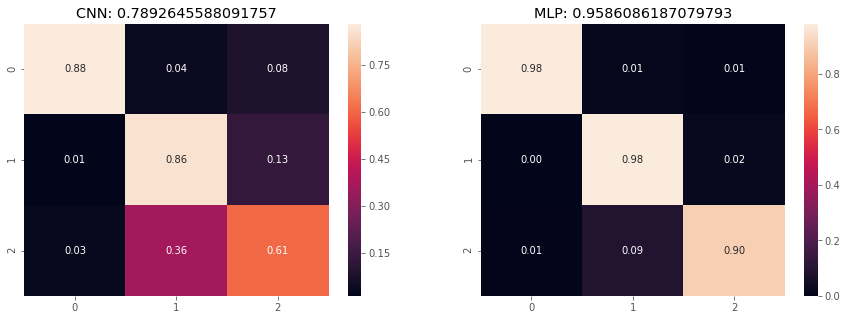

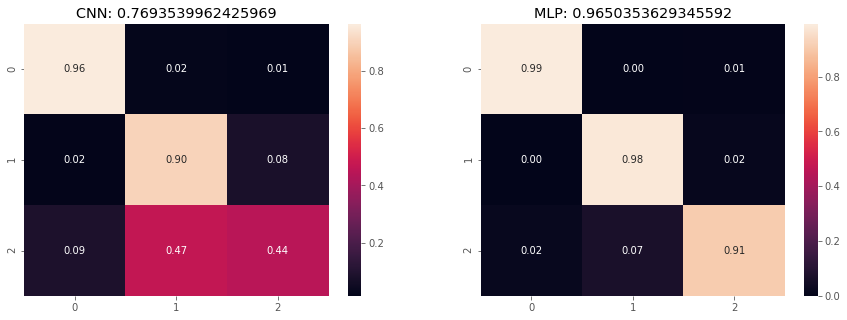

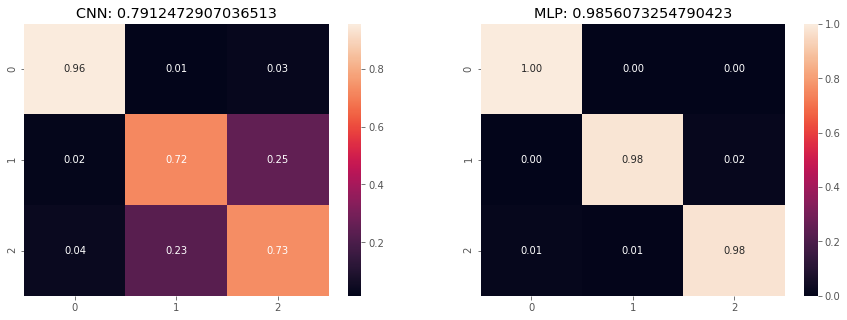

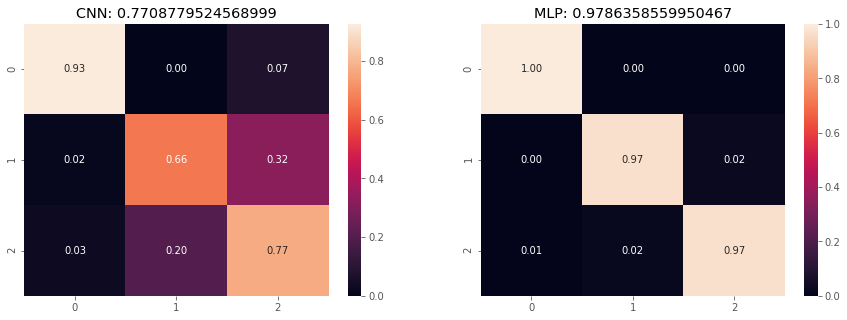

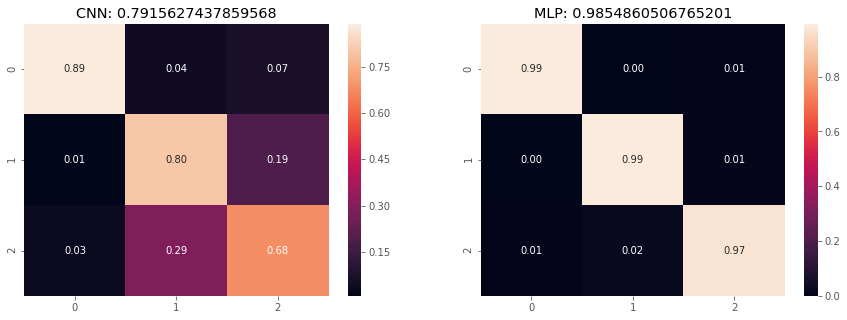

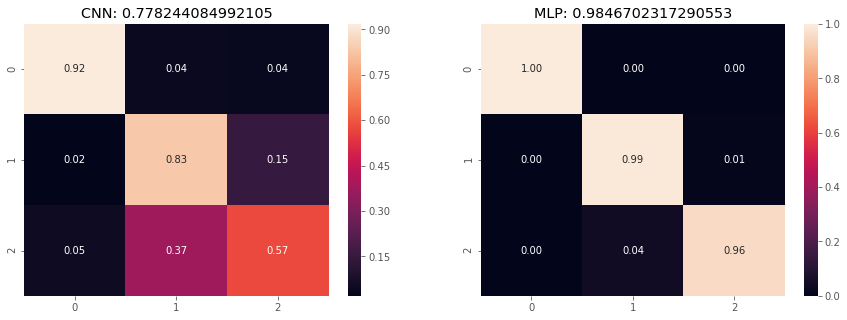

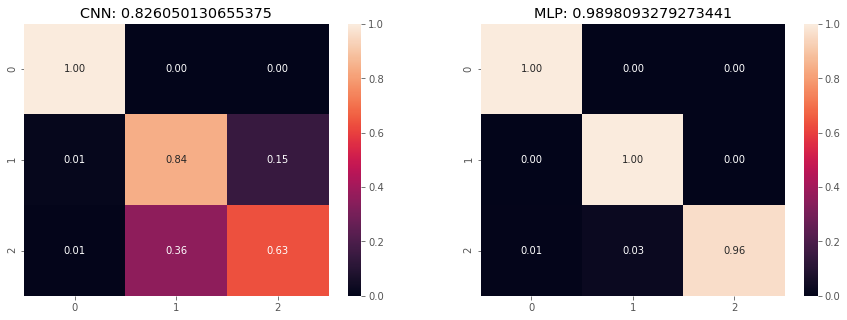

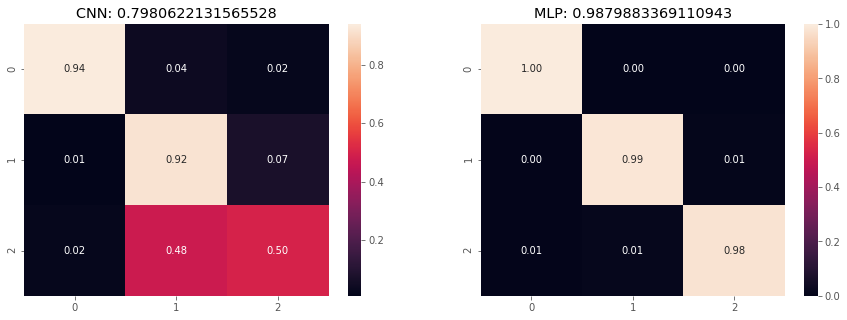

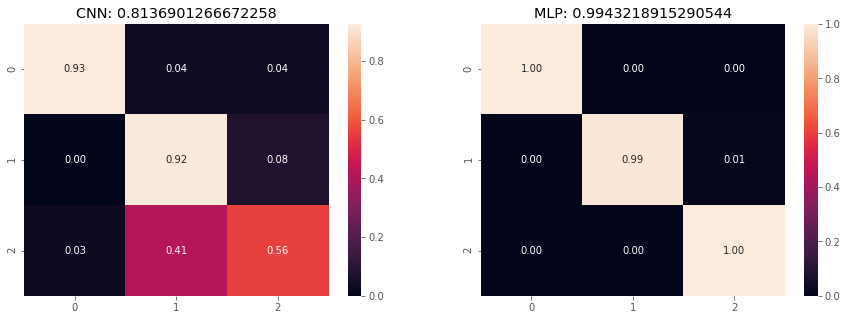

In [429]:
# Let's train the model 
cnn_history=[]
mlp_history=[]
history_first=[]
mlp_his = []

classifier_cnn_first = []
classifier_mlp_first = []
for i in range(10):
    print('Fold:' + str(i+1))
    #simple cnn
    # we need to exapnd the dimensions here to give the 
    # "channels" dimension expected by Keras
    history =  cnn.fit(np.expand_dims(train_pca_200[i], axis=1), y_train_ohe[i], 
               batch_size=32, epochs=epochs, 
               shuffle=True, verbose=0,
               validation_data=(np.expand_dims(test_pca_200[i], axis=1),y_test_ohe[i]))
    
    cnn_history.append(cnn)
    history_first.append(history)
    #mlp
    print('MLP')
    mlp_model = mlp.fit(train_pca_200[i], y_train_ohe[i], 
            batch_size=32, epochs=10, 
            shuffle=True, verbose=1,
           validation_data=(test_pca_200[i],y_test_ohe[i]))
    mlp_history.append(mlp)
    mlp_his.append(mlp_model)

    classifier_cnn_first.append(contingency_column(cnn_history[i], test_pca_200[i],y_test[i]))
    classifier_mlp_first.append(contingency_column_mlp(mlp_history[i], test_pca_200[i],y_test[i]))
    compare_mlp_cnn(cnn_history[i],mlp_history[i],test_pca_200[i],y_test[i])

From above we can see that our cnn1 model does not perform well for class 3, pneumonia virus, which has a much lower F1 score compared to mlp model.

In [430]:
history_first[0].history['val_f1']

[0.39603638648986816,
 0.3976963460445404,
 0.42507076263427734,
 0.42045190930366516,
 0.4151526093482971,
 0.4195258915424347,
 0.40792495012283325,
 0.3799225091934204,
 0.41920235753059387,
 0.41273489594459534]

In [431]:
np.expand_dims(train_pca_200[0], axis=1).shape

(4693, 1, 200)

# Second CNN

In [432]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add( Reshape((1,w,h), input_shape=(1,200)) )
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(1,w,h),
                data_format="channels_first") )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy',f1])

CPU times: user 112 ms, sys: 43.2 ms, total: 155 ms
Wall time: 177 ms


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


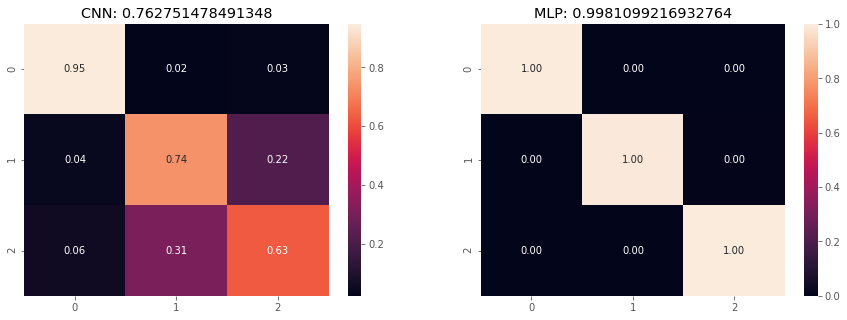

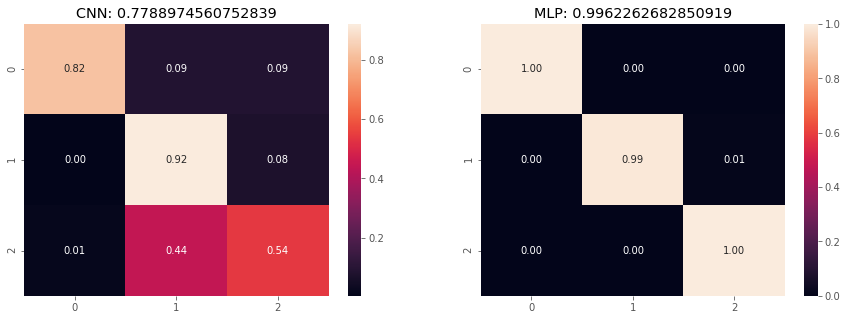

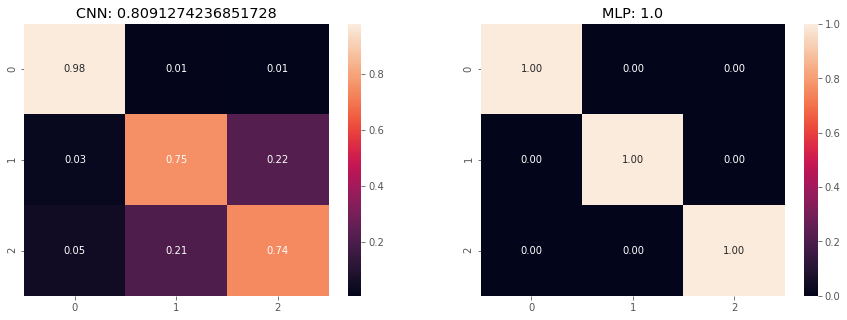

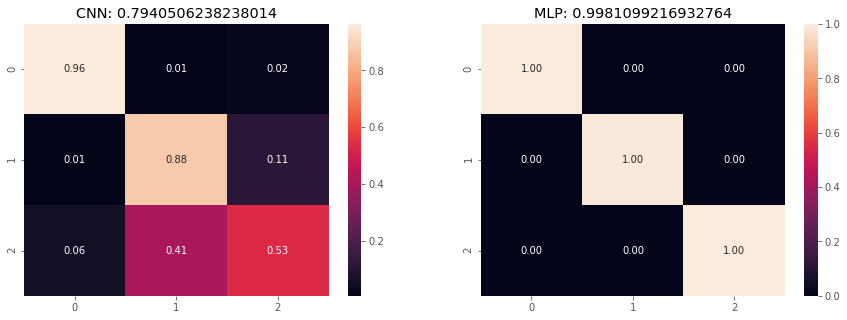

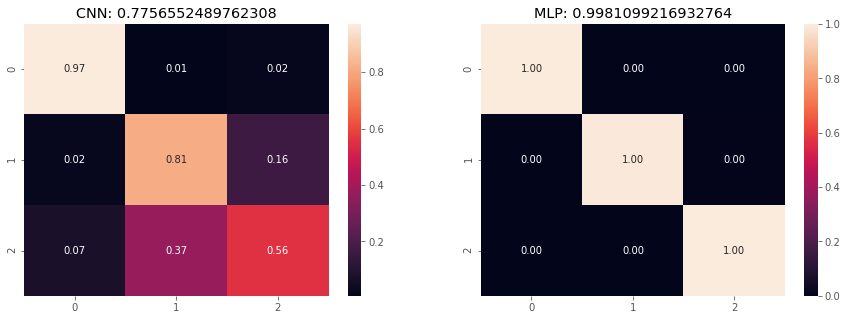

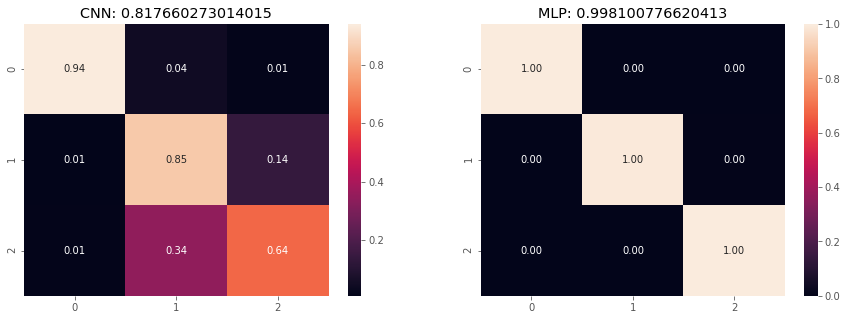

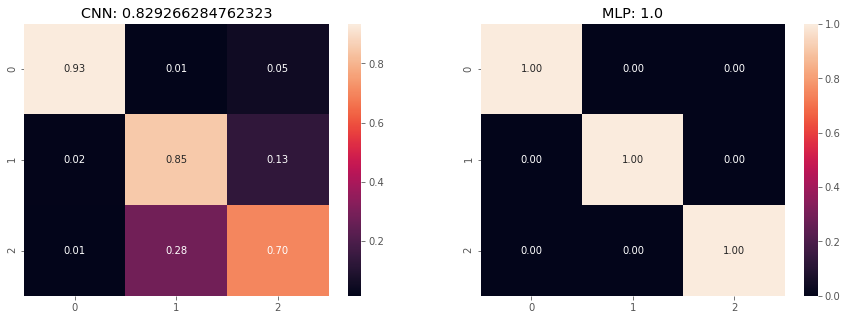

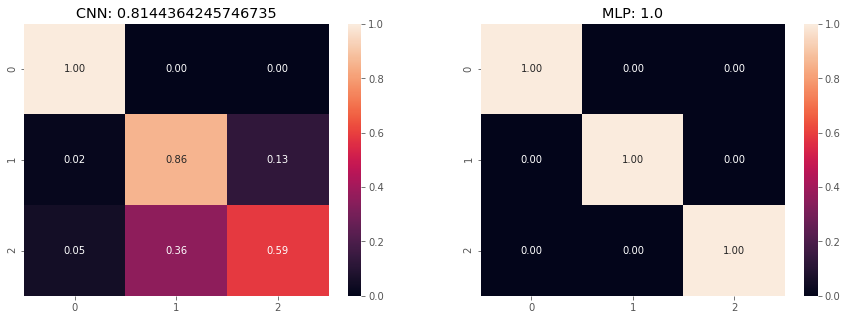

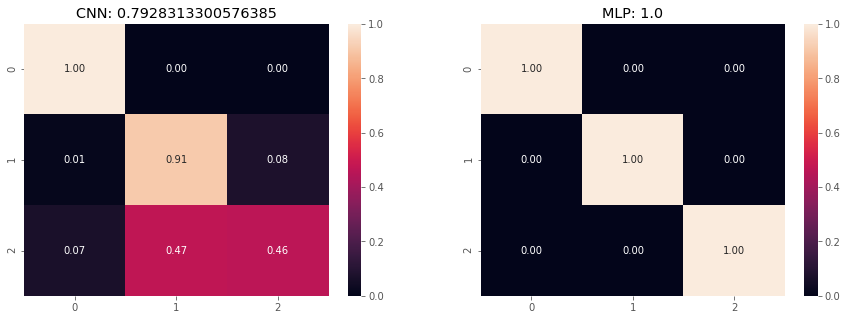

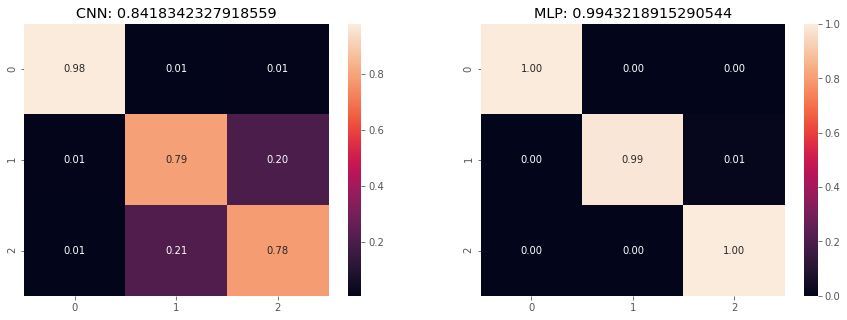

In [433]:
# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2_history = []
history_second = []
classifier_2 = []

for i in range(10):
    print("fold: " + str(i+1))
    history =  cnn2.fit(np.expand_dims(train_pca_200[i], axis=1), y_train_ohe[i], 
               batch_size=32, epochs=epochs, 
               shuffle=True, verbose=0,
               validation_data=(np.expand_dims(test_pca_200[i], axis=1),y_test_ohe[i]))
    cnn2_history.append(cnn2)
    history_second.append(history)
    
    classifier_2.append(contingency_column(cnn2_history[i], test_pca_200[i], y_test[i]))
    compare_mlp_cnn(cnn2_history[i],mlp_history[i],test_pca_200[i],y_test[i])

From above we can see that our cnn2 model does not perform well for class 3, pneumonia virus, which has a much lower F1 score compared to mlp model.

In [434]:
history_second[0].history['val_f1']

[0.3713720440864563,
 0.42548319697380066,
 0.4241640567779541,
 0.3974648118019104,
 0.36863332986831665,
 0.4249395728111267,
 0.4182492792606354,
 0.3767850399017334,
 0.36451637744903564,
 0.43276458978652954]

# Third CNN

In [435]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
#    3. increase filter_layer from 16 to 32
cnn3 = Sequential()
cnn3.add( Reshape((1,w,h), input_shape=(1,200)))

num_filt_layers = [32, 32] 
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_first") )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy',f1])

CPU times: user 122 ms, sys: 26.5 ms, total: 148 ms
Wall time: 179 ms


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


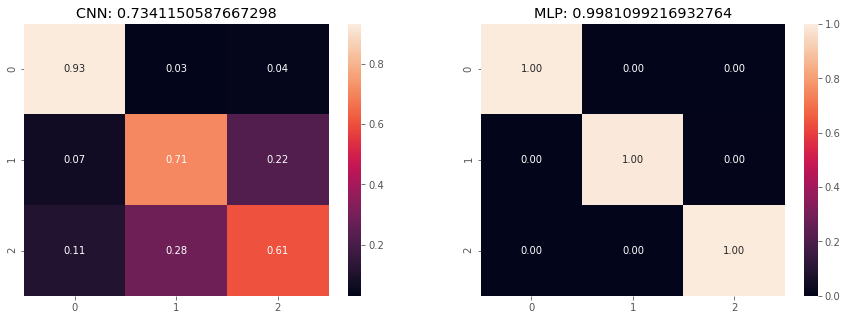

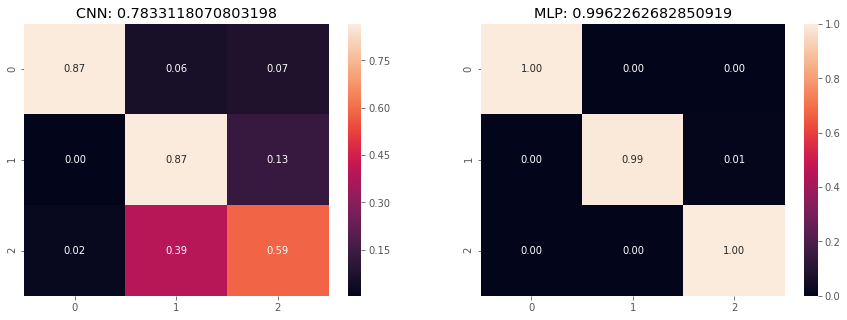

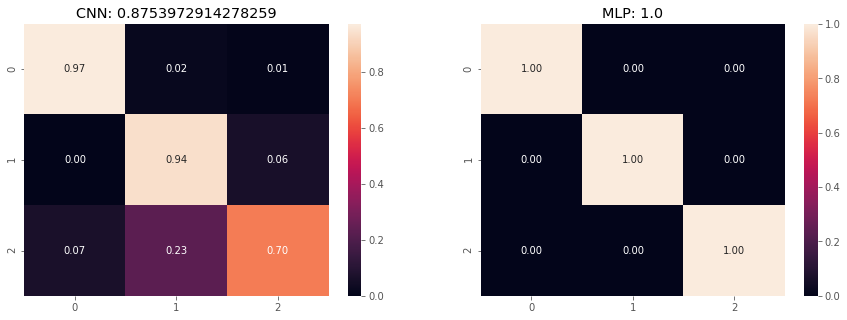

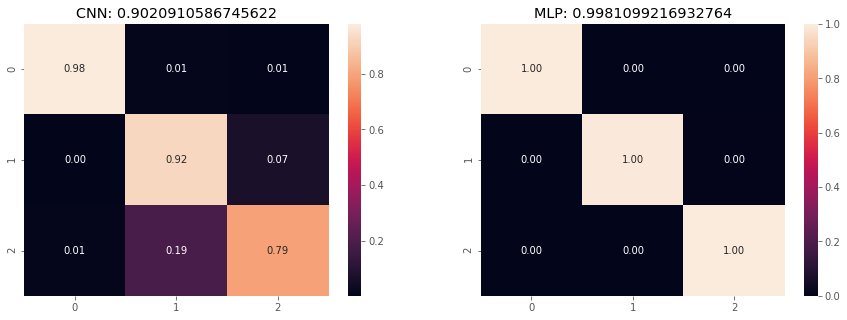

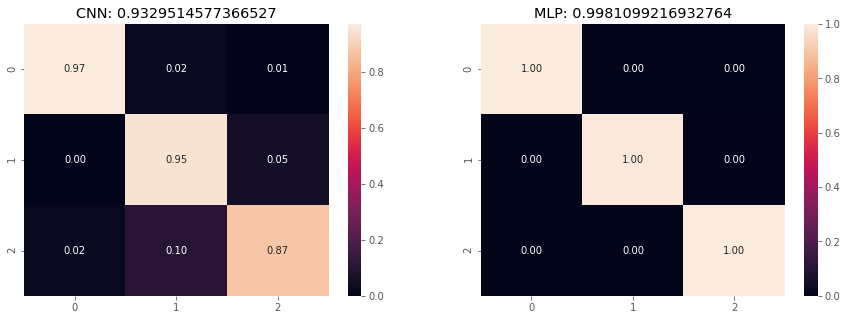

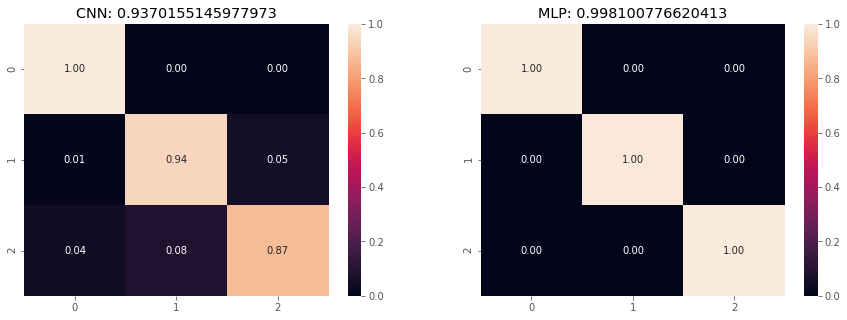

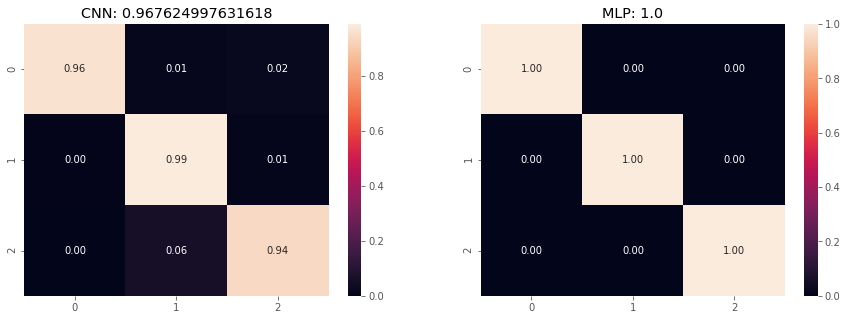

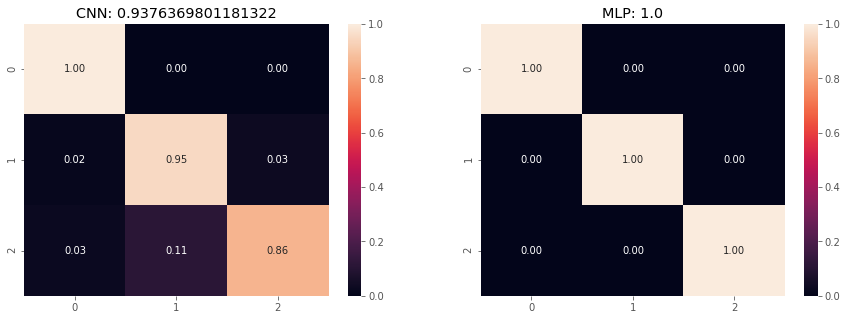

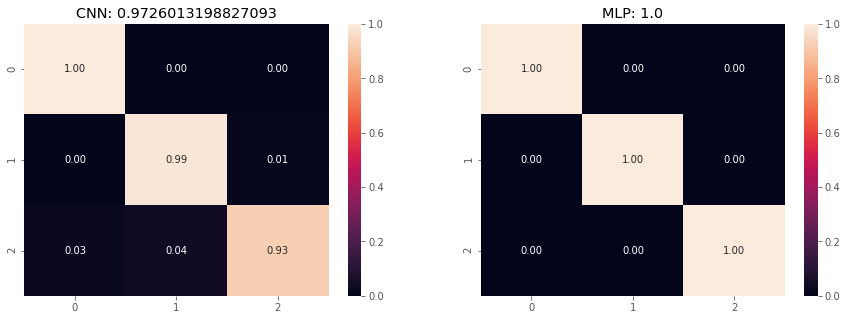

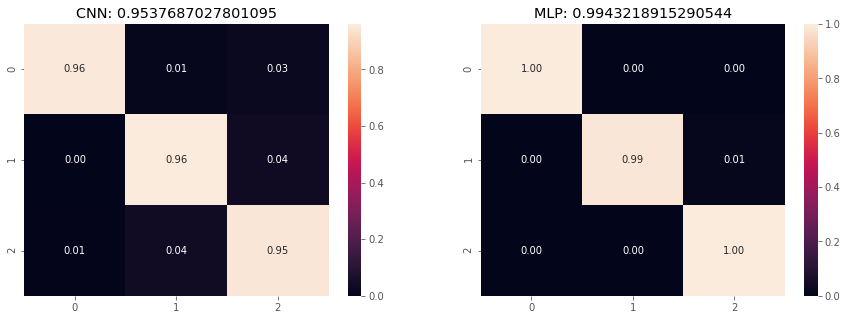

In [436]:
# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn3_history = []
history_third = []
classifier_3 = []

for i in range(10):
    print("fold: " + str(i+1))
    history =  cnn3.fit(np.expand_dims(train_pca_200[i], axis=1), y_train_ohe[i], 
               batch_size=32, epochs=epochs, 
               shuffle=True, verbose=0,
               validation_data=(np.expand_dims(test_pca_200[i], axis=1),y_test_ohe[i]))
    cnn3_history.append(cnn3)
    history_third.append(history)
    classifier_3.append(contingency_column(cnn3_history[i], test_pca_200[i], y_test[i]))
    compare_mlp_cnn(cnn3_history[i],mlp_history[i],test_pca_200[i],y_test[i])

From above we can see that our cnn3 model performs equally well for all classes.

In [437]:
history_third[0].history['val_f1']

[0.34694933891296387,
 0.4086058735847473,
 0.38811802864074707,
 0.40020719170570374,
 0.4150916635990143,
 0.4147535562515259,
 0.39099401235580444,
 0.343827486038208,
 0.41264405846595764,
 0.41969284415245056]

# Fourth CNN

In [493]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters from 32 to 48
#    3. add more layers once flattened
#    4. add regularization l2
cnn4 = Sequential()
cnn4.add( Reshape((1,w,h), input_shape=(1,200)) )

num_filt_layers = [48, 48]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_first"))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100, kernel_regularizer = l2(0.001)))
cnn4.add( Activation('relu') )
cnn4.add( Dense(CLASSES, kernel_regularizer = l2(0.001)))
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy',f1])

CPU times: user 150 ms, sys: 51.2 ms, total: 202 ms
Wall time: 247 ms


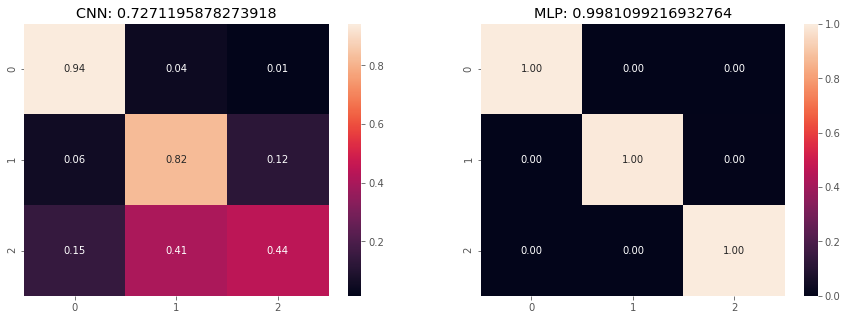

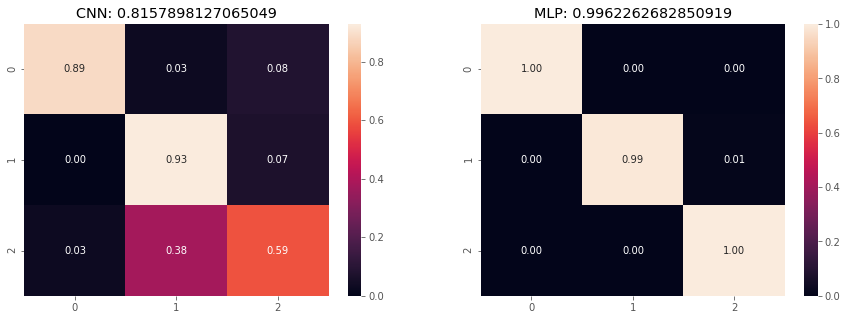

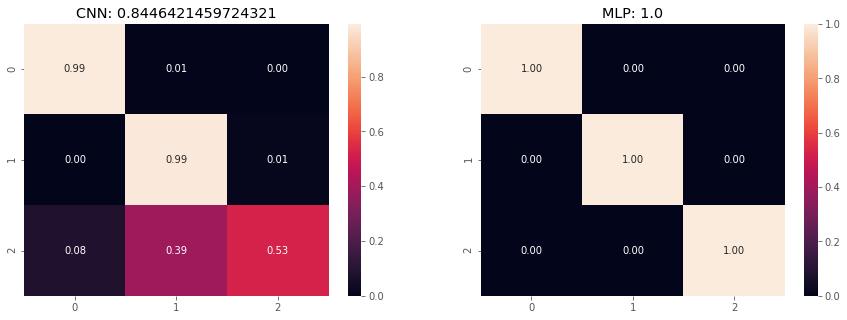

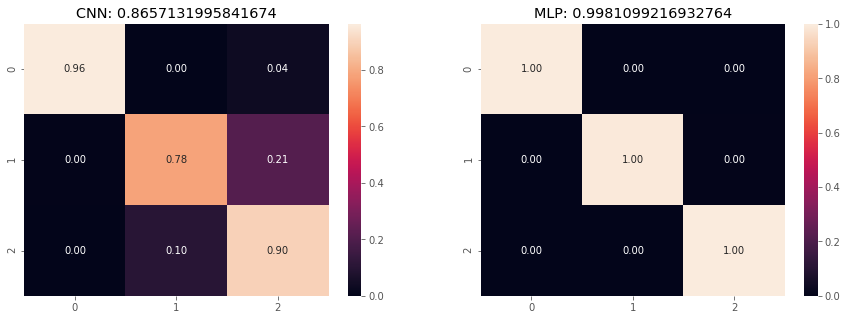

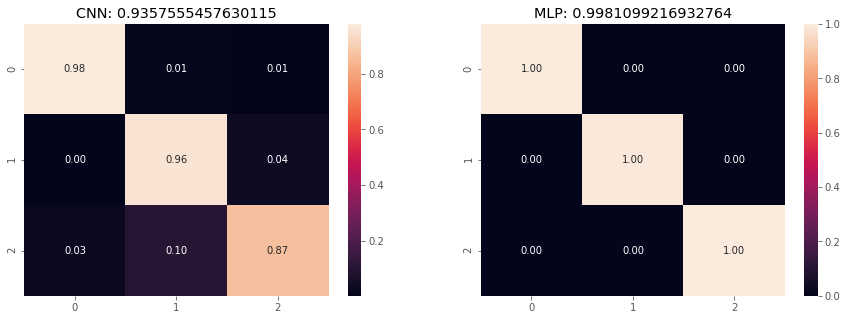

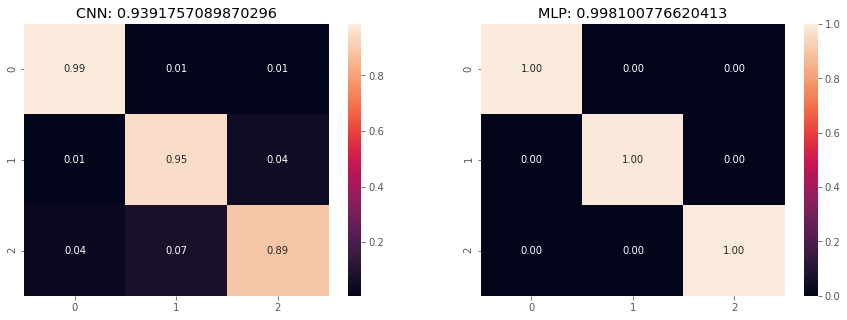

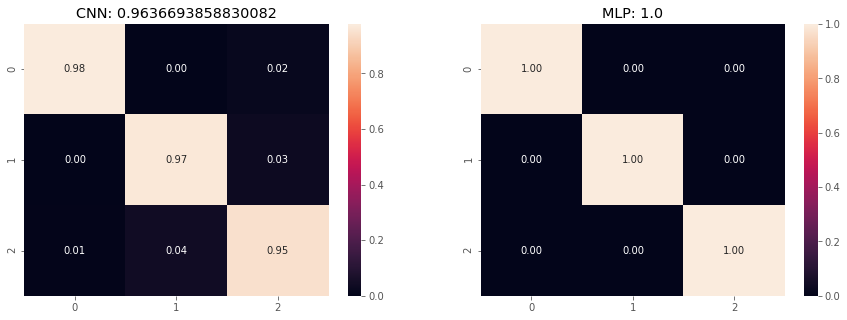

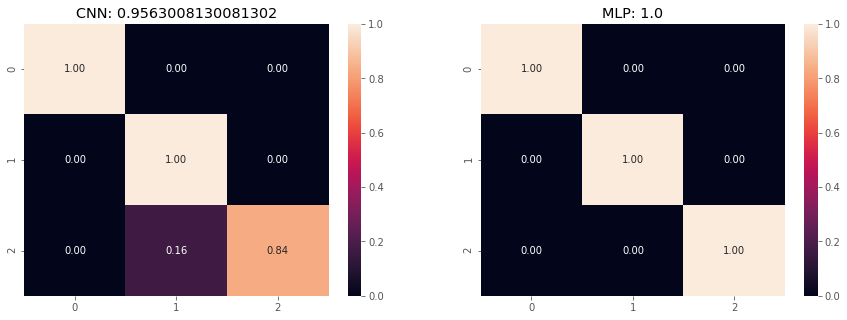

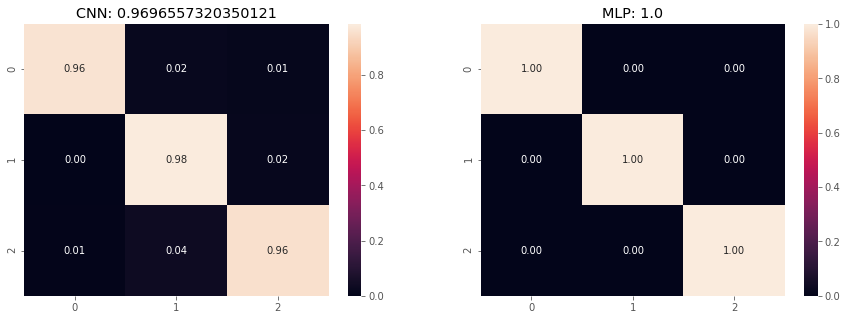

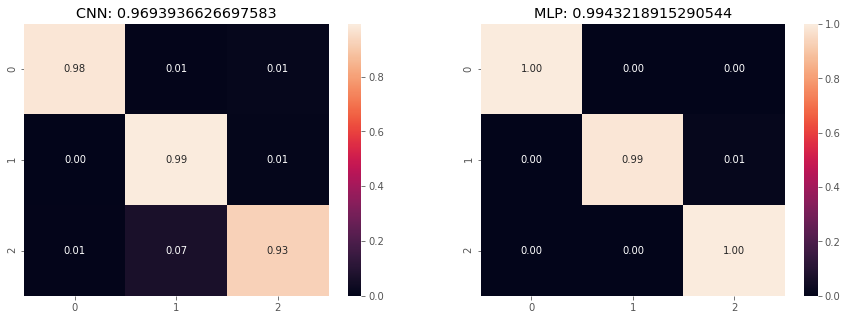

In [494]:
# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4_history = []
history_fourth = []
classifier_4 = []

for i in range(10):
    history =  cnn4.fit(np.expand_dims(train_pca_200[i], axis=1), y_train_ohe[i], 
               batch_size=32, epochs=epochs, 
               shuffle=True, verbose=0,
               validation_data=(np.expand_dims(test_pca_200[i], axis=1),y_test_ohe[i]))
    cnn4_history.append(cnn4)
    history_fourth.append(history)
    classifier_4.append(contingency_column(cnn4_history[i], test_pca_200[i], y_test[i]))
    compare_mlp_cnn(cnn4_history[i],mlp_history[i],test_pca_200[i],y_test[i])

From above we can see that our cnn4 model performs well for all the classes.

In [496]:
history_fourth[0].history['val_f1']

[0.391178697347641,
 0.391316294670105,
 0.36063656210899353,
 0.4113733172416687,
 0.426849365234375,
 0.4404926598072052,
 0.4152337610721588,
 0.42303594946861267,
 0.4172334372997284,
 0.41718369722366333]

# Using more advanced CNN

In [441]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

train_pca_reshape=[]
test_pca_reshape=[]
datagen_history=[]

for i in range(10):
    train_pca_temp = train_pca_200[i].reshape(len(train_pca_200[i]),w,h,1)
    test_pca_temp = test_pca_200[i].reshape(len(test_pca_200[i]),w,h,1)

    datagen.fit(train_pca_temp)
    train_pca_reshape.append(train_pca_temp)
    test_pca_reshape.append(test_pca_temp)
    datagen_history.append(datagen)
for i in range(10):
    train_pca_temp = train_pca_200[i].reshape(len(train_pca_200[i]),w,h,1)
    test_pca_temp = test_pca_200[i].reshape(len(test_pca_200[i]),w,h,1)

    datagen.fit(train_pca_temp)
    train_pca_reshape.append(train_pca_temp)
    test_pca_reshape.append(test_pca_temp)
    datagen_history.append(datagen)

In [442]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    f1 = mt.f1_score(y_test,yhat,average = "macro")
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(f1))

# Advanced CNN1

In [443]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (w,h,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy',f1])

CPU times: user 542 ms, sys: 33.8 ms, total: 576 ms
Wall time: 168 ms


In [446]:
# the flow method yields batches of images indefinitely, with the given transformations
cnn_generator = []
history_cnn=[]

classifier_adv = []
for i in range(10):
    print("fold: " + str(i+1))
    history = cnn.fit_generator(datagen.flow(train_pca_reshape[i], y_train_ohe[i], batch_size=128), 
                   steps_per_epoch=int(len(train_pca_reshape[i])/128), # how many generators to go through per epoch
                   epochs=epochs, verbose=1,validation_data=(test_pca_reshape[i],y_test_ohe[i]),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
                   
    history_cnn.append(history)
    #pred = np.round(np.argmax(cnn.predict(X_test[i]),axis=1))
    #c = f1_score(np.round(np.argmax(y_test_ohe[i],axis =1)), pred)
    cnn_generator.append(cnn)
    classifier_adv.append(contingency_column_mlp(cnn_generator[i], test_pca_200[i], y_test[i]))
    

fold: 1
Epoch 1/10
36/36 [==============================] - 2s 57ms/step - loss: 0.8586 - accuracy: 0.6094 - f1: 0.4729 - val_loss: 0.7636 - val_accuracy: 0.6750 - val_f1: 0.3397
Epoch 2/10
36/36 [==============================] - 2s 54ms/step - loss: 0.8571 - accuracy: 0.6142 - f1: 0.4719 - val_loss: 0.7386 - val_accuracy: 0.6807 - val_f1: 0.3622
Epoch 3/10
36/36 [==============================] - 2s 54ms/step - loss: 0.8508 - accuracy: 0.6230 - f1: 0.4726 - val_loss: 0.8263 - val_accuracy: 0.6291 - val_f1: 0.3180
Epoch 4/10
36/36 [==============================] - 2s 53ms/step - loss: 0.8490 - accuracy: 0.6140 - f1: 0.4808 - val_loss: 0.8210 - val_accuracy: 0.6252 - val_f1: 0.3089
fold: 2
Epoch 1/10
36/36 [==============================] - 2s 53ms/step - loss: 0.8400 - accuracy: 0.6180 - f1: 0.4818 - val_loss: 0.7146 - val_accuracy: 0.7011 - val_f1: 0.3646
Epoch 2/10
36/36 [==============================] - 2s 55ms/step - loss: 0.8418 - accuracy: 0.6200 - f1: 0.4871 - val_loss: 0.674

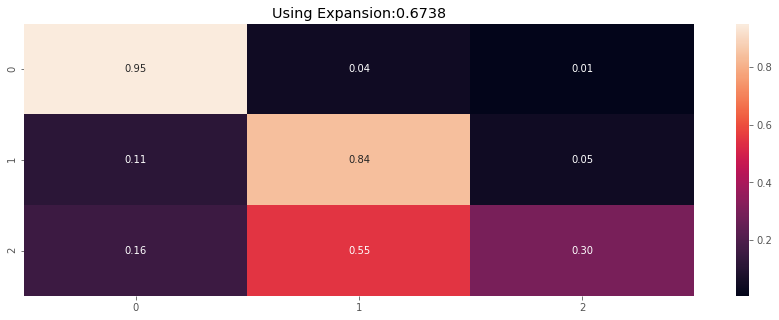

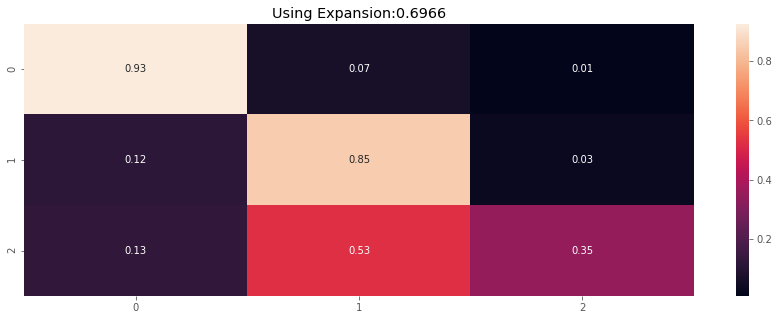

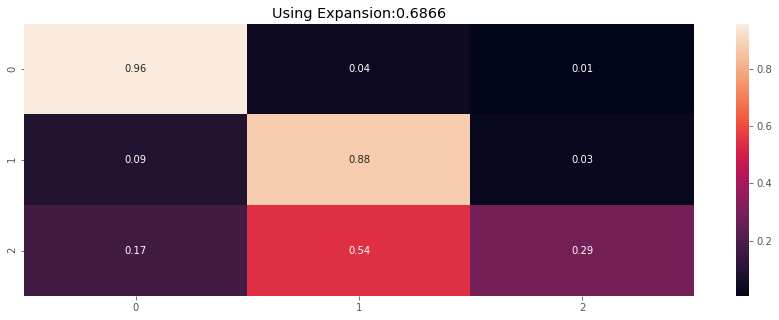

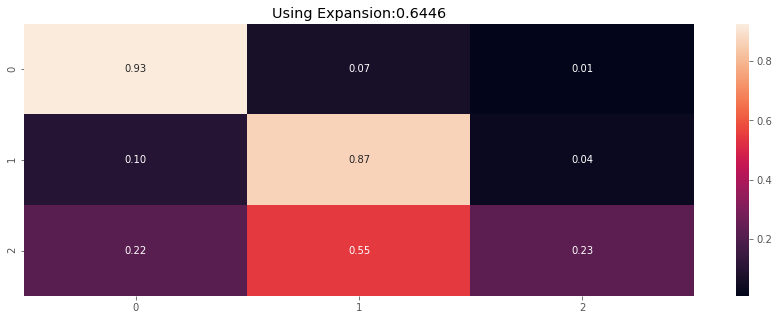

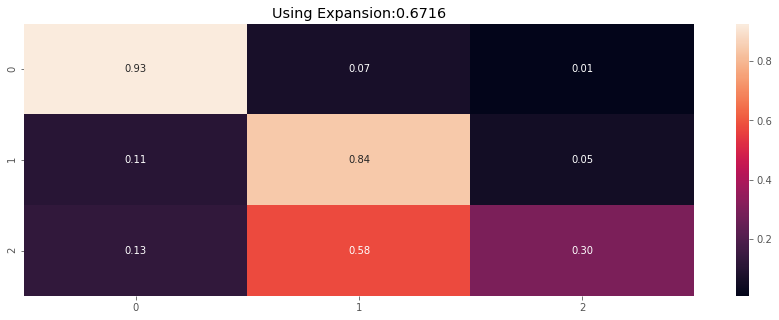

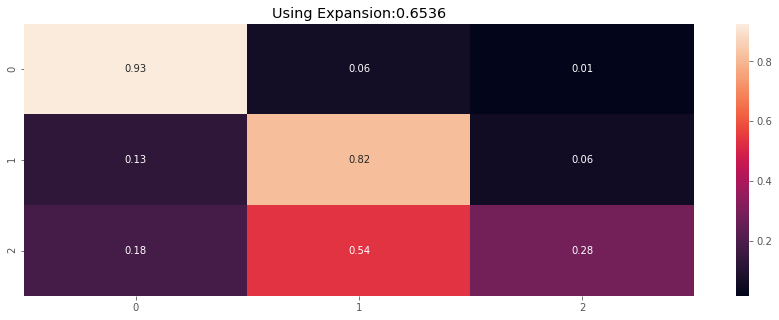

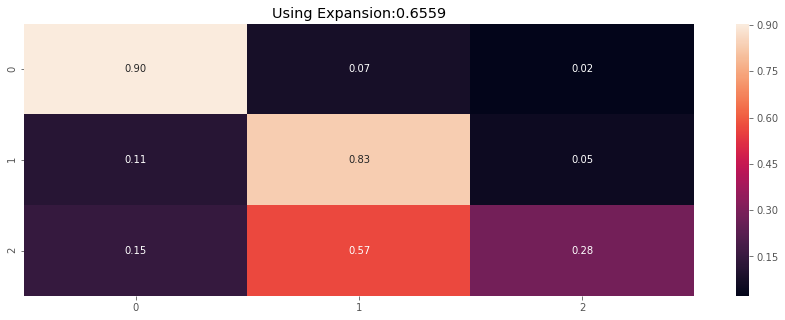

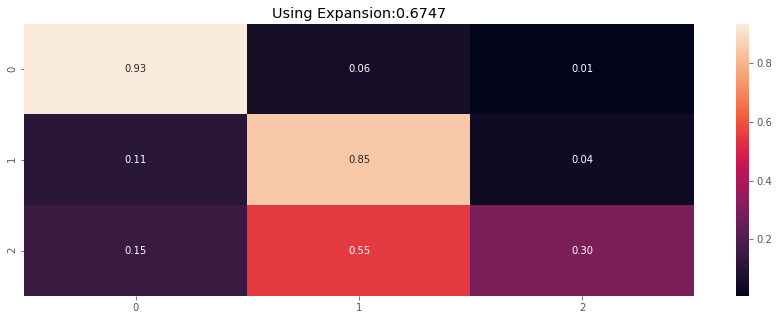

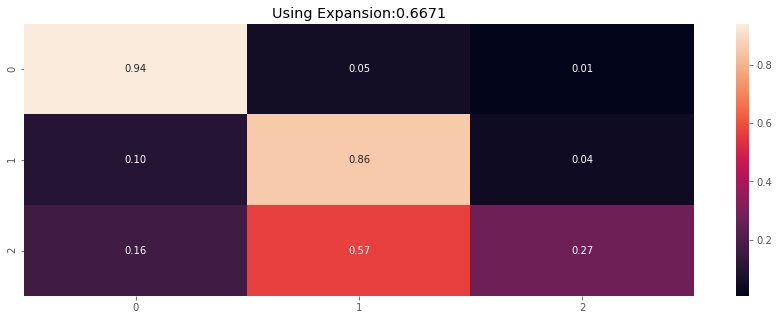

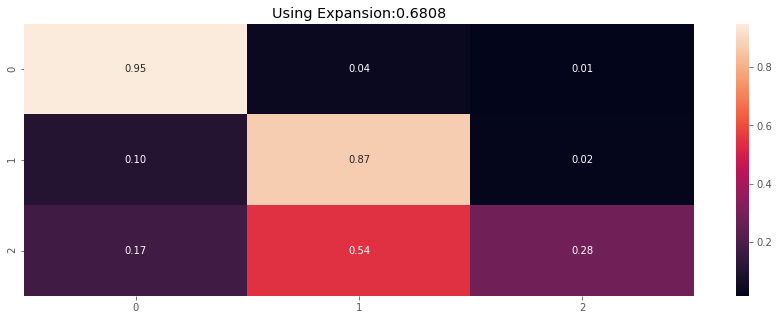

In [447]:
for i in range(10):
    summarize_net(cnn_generator[i], test_pca_reshape[i], y_test[i], title_text='Using Expansion:')

From above we can see that our advanced cnn1 model performs bad for class 3, pneumonia virus, which has a F1 score around 0.3.

# Advanced CNN2

In [448]:
#Use the Validation Data
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (w,h,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (w,h,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (w,h,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy',f1])

In [449]:
# the flow method yields batches of images indefinitely, with the given transformations
cnn_generator_2 = []
history_cnn_2=[]
classifier_adv2 = []

for i in range(10):
    print("fold: " + str(i+1))
    history = cnn.fit_generator(datagen.flow(train_pca_reshape[i], y_train_ohe[i], batch_size=128), 
                   steps_per_epoch=int(len(train_pca_reshape[i])/128), # how many generators to go through per epoch
                   epochs=epochs, verbose=1,validation_data=(test_pca_reshape[i],y_test_ohe[i]),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    history_cnn_2.append(history)
    #pred = np.round(np.argmax(cnn.predict(X_test[i]),axis=1))
    #c = accuracy_score(np.round(np.argmax(y_test_ohe[i],axis =1)), pred)
    cnn_generator_2.append(cnn)
    classifier_adv2.append(contingency_column_mlp(cnn_generator_2[i], test_pca_200[i], y_test[i]))


fold: 1
Epoch 1/10
36/36 [==============================] - 3s 94ms/step - loss: 2.3218 - accuracy: 0.4390 - f1: 0.1486 - val_loss: 1.1277 - val_accuracy: 0.4857 - val_f1: 0.1109
Epoch 2/10
36/36 [==============================] - 4s 115ms/step - loss: 1.1801 - accuracy: 0.4629 - f1: 0.1244 - val_loss: 1.1037 - val_accuracy: 0.5392 - val_f1: 0.0823
Epoch 3/10
36/36 [==============================] - 4s 113ms/step - loss: 1.1597 - accuracy: 0.4784 - f1: 0.1270 - val_loss: 1.0480 - val_accuracy: 0.6042 - val_f1: 0.1693
Epoch 4/10
36/36 [==============================] - 4s 122ms/step - loss: 1.1388 - accuracy: 0.4957 - f1: 0.1727 - val_loss: 1.0141 - val_accuracy: 0.5870 - val_f1: 0.2166
Epoch 5/10
36/36 [==============================] - 4s 118ms/step - loss: 1.0921 - accuracy: 0.5400 - f1: 0.2480 - val_loss: 1.1174 - val_accuracy: 0.4971 - val_f1: 0.1642
Epoch 6/10
36/36 [==============================] - 3s 93ms/step - loss: 1.0886 - accuracy: 0.5266 - f1: 0.2434 - val_loss: 0.9842 - 

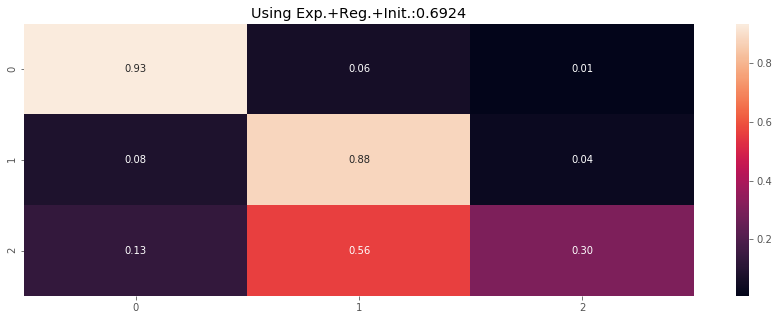

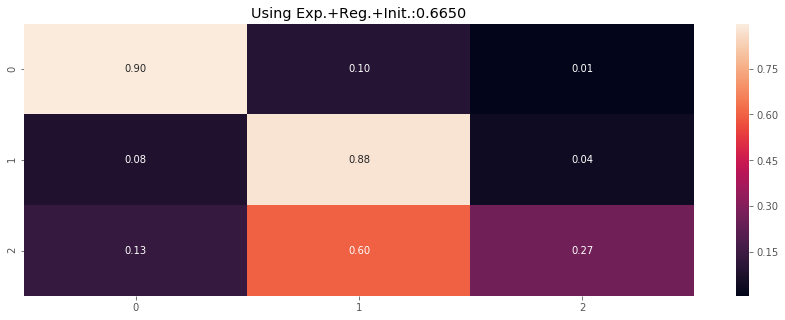

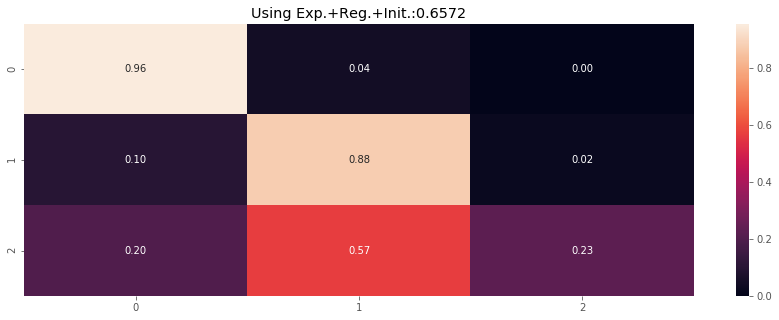

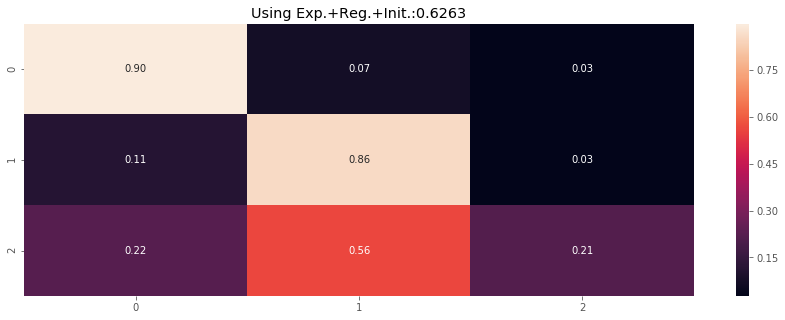

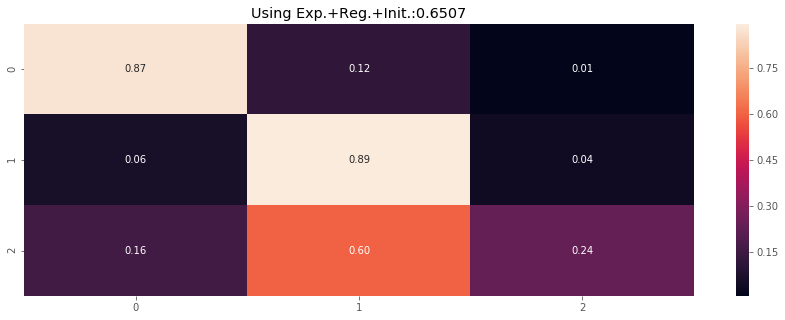

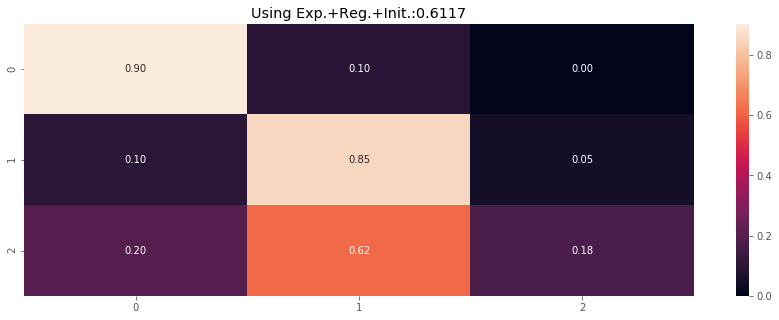

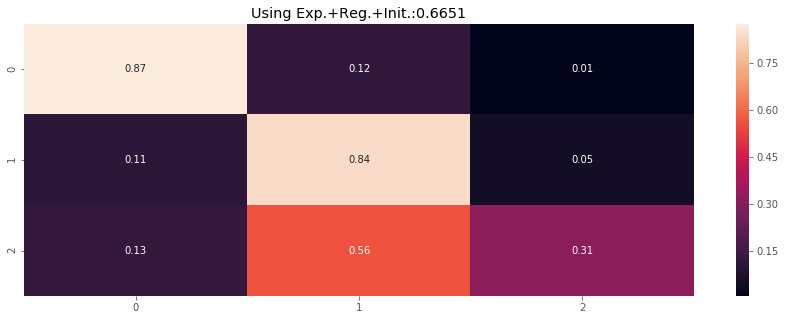

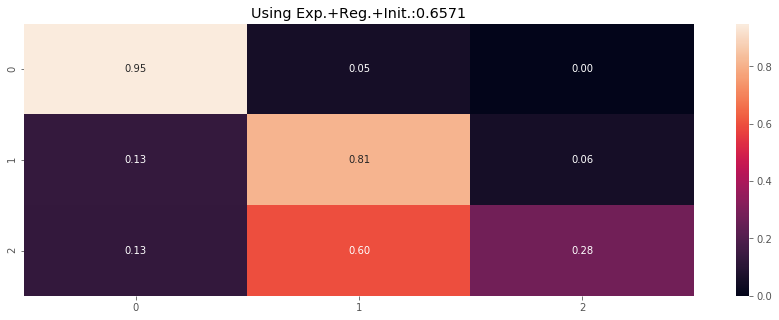

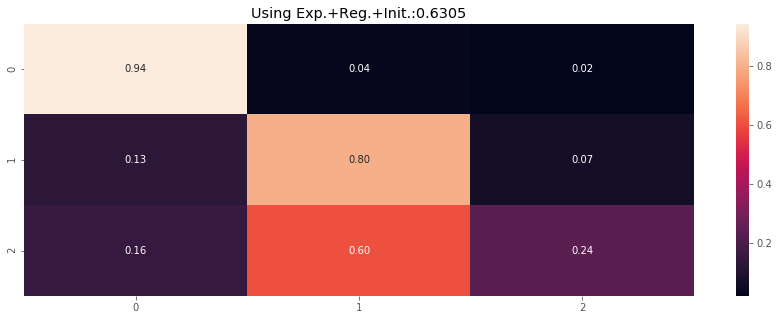

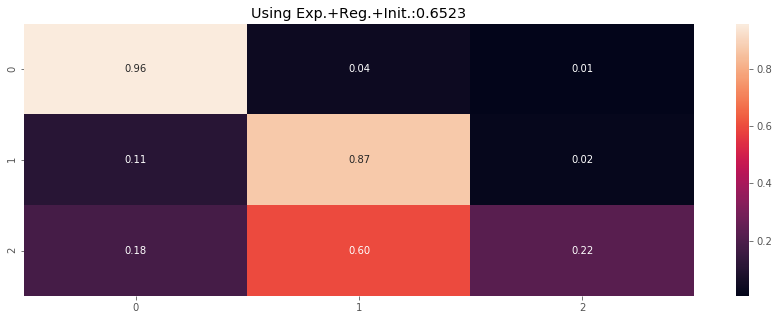

In [450]:
for i in range(10):
    summarize_net(cnn_generator_2[i], test_pca_reshape[i], y_test[i], title_text='Using Exp.+Reg.+Init.:')

From above we can see that our advanced cnn2 model performs bad for class 3, pneumonia virus, which has a F1 score as low as 0.2.

# Compare Performance of the Training and Validation sets 

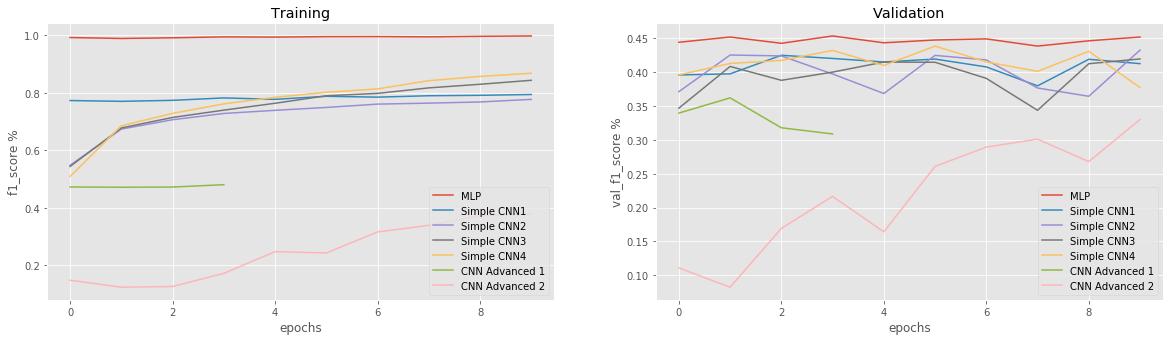

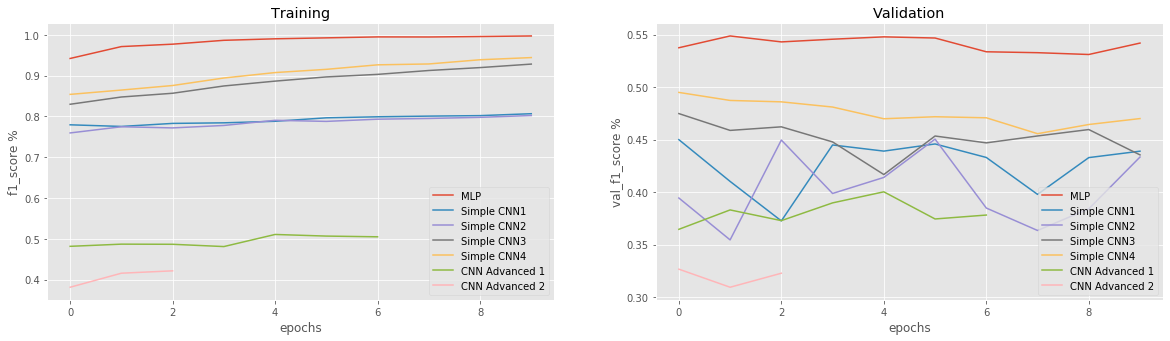

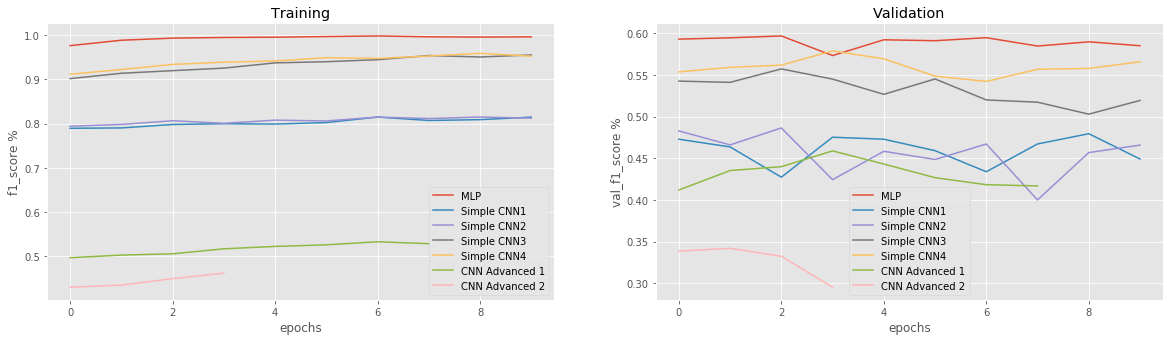

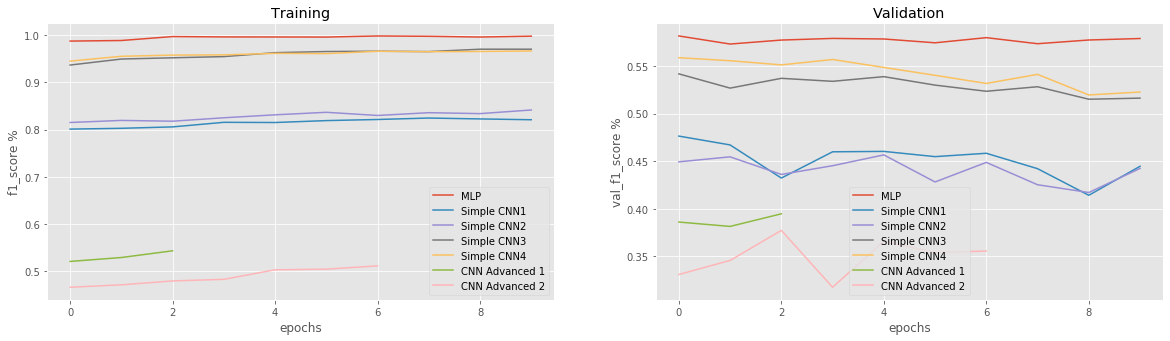

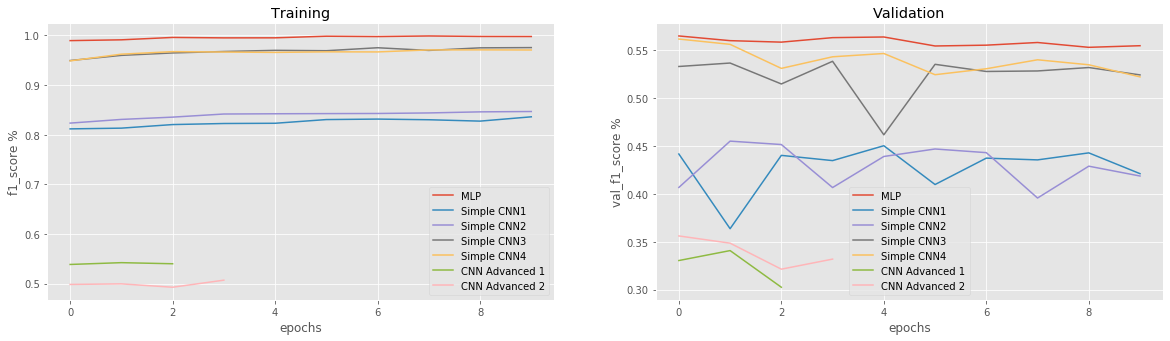

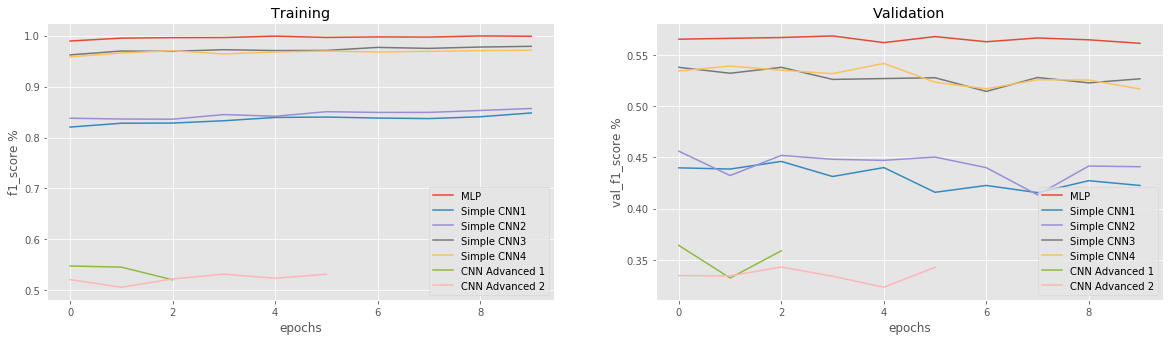

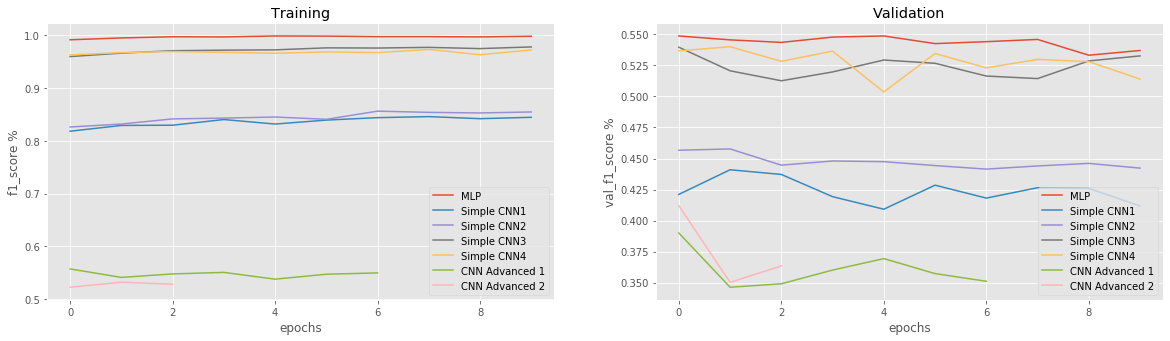

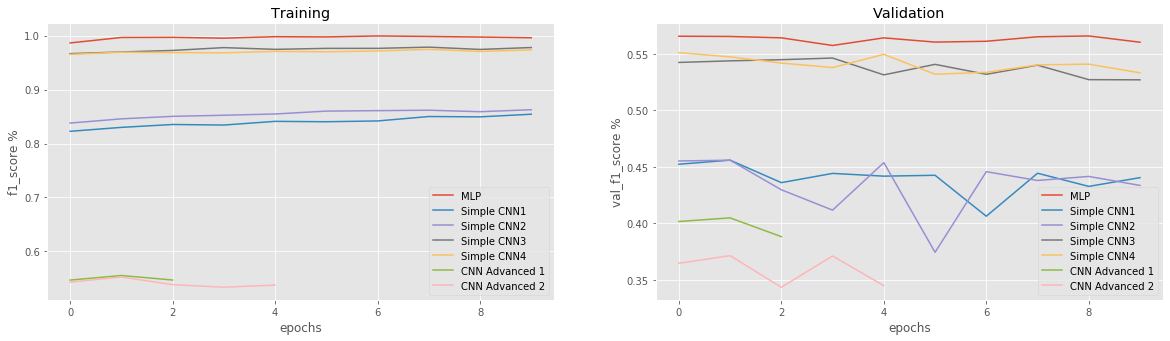

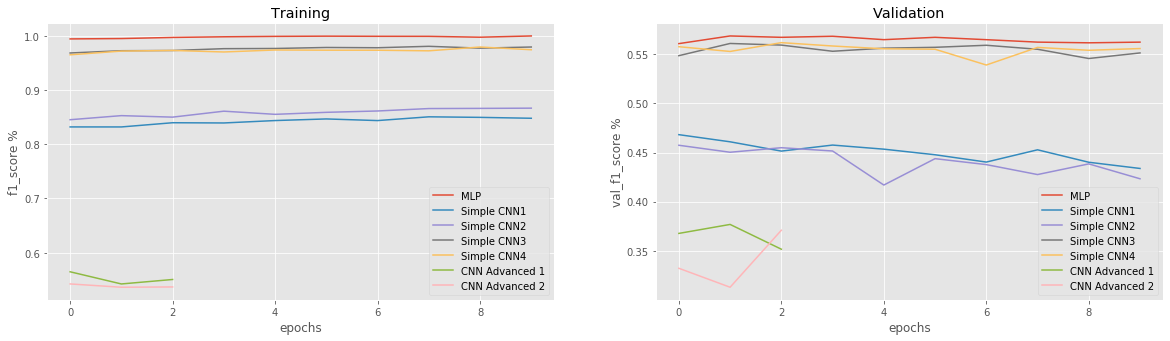

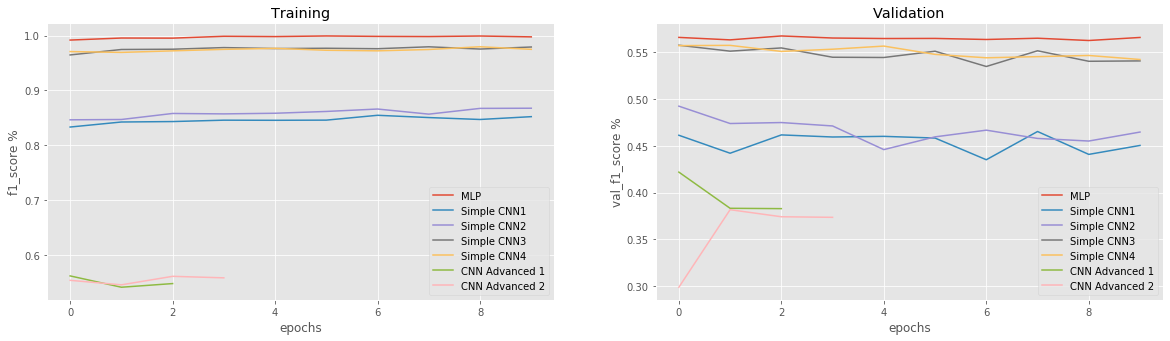

In [451]:
%matplotlib inline
for i in range(10):
    legends=['MLP','Simple CNN1','Simple CNN2','Simple CNN3','Simple CNN4','CNN Advanced 1','CNN Advanced 2']
    plt.figure(figsize=(20,60))
    plt.subplot(10,2,1)
    plt.plot(mlp_his[i].history['f1'])
    plt.plot(history_first[i].history['f1'])
    plt.plot(history_second[i].history['f1'])
    plt.plot(history_third[i].history['f1'])
    plt.plot(history_fourth[i].history['f1'])
    plt.plot(history_cnn[i].history['f1'])
    plt.plot(history_cnn_2[i].history['f1'])
    plt.legend(legends)
    plt.xlabel('epochs')
    plt.ylabel('f1_score %')
    plt.title('Training')
    plt.subplot(10,2,2)
    plt.plot(mlp_his[i].history['val_f1'])
    plt.plot(history_first[i].history['val_f1'])
    plt.plot(history_second[i].history['val_f1'])
    plt.plot(history_third[i].history['val_f1'])
    plt.plot(history_fourth[i].history['val_f1'])
    plt.plot(history_cnn[i].history['val_f1'])
    plt.plot(history_cnn_2[i].history['val_f1'])
    plt.legend(legends)
    plt.xlabel('epochs')
    plt.ylabel('val_f1_score %')
    plt.title('Validation')

MLP performs best compared to all the cnn models for both training and validation set. Our F1 score for validation set is much lower than the training set for all our models. But according to the validation F1 score using sklearn, we do not see the same magnitude of the decrease.  We are unsure why this is happening because our model trains very well on the test set and then it performs poorly on the validation set. This means that our model must be overtraining somehow. We also l2 regularization and drop out to prevent overfitting problem but it does not make a difference.If we adapted the parameters some more, we may have found a way to prevent this overtraining. 

In [452]:
Methods = ['MLP','Simple CNN1','Simple CNN2','Simple CNN3','Simple CNN4','CNN Advanced 1','CNN Advanced 2']

print('| {:^8} | {:^15} | {:^21}| {:^21} '.format('fold','Method','f1','validate f1'))
print('| {:^8} | {:^15} | {:^21}| {:^21} '.format('', '', '', '', ''))

for i in range(10):
    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[0],np.mean(mlp_his[i].history['f1']),np.mean(mlp_his[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[1],np.mean(history_first[i].history['f1']),np.mean(history_first[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[2],np.mean(history_second[i].history['f1']),np.mean(history_second[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[3],np.mean(history_third[i].history['f1']),np.mean(history_third[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[4],np.mean(history_fourth[i].history['f1']),np.mean(history_fourth[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[5],np.mean(history_cnn[i].history['f1']),np.mean(history_cnn[i].history['val_f1'])))

    print('| {:^8} | {:^15} | {:^21}| {:^21}  '.format(i+1,Methods[6],np.mean(history_cnn_2[i].history['f1']),np.mean(history_cnn_2[i].history['val_f1'])))


|   fold   |     Method      |          f1          |      validate f1      
|          |                 |                      |                       
|    1     |       MLP       |  0.9940503239631653  |  0.4470693439245224    
|    1     |   Simple CNN1   |  0.7825987339019775  |  0.4093718618154526    
|    1     |   Simple CNN2   |  0.7216504216194153  |  0.4004372298717499    
|    1     |   Simple CNN3   |  0.7519026398658752  |  0.39408840537071227   
|    1     |   Simple CNN4   |  0.7653467059135437  |  0.4132735162973404    
|    1     | CNN Advanced 1  |  0.4745631217956543  |   0.332185797393322    
|    1     | CNN Advanced 2  |  0.24722325801849365 |  0.21931340247392656   
|    2     |       MLP       |  0.9842848777770996  |  0.5408697187900543    
|    2     |   Simple CNN1   |   0.791621744632721  |  0.4265595316886902    
|    2     |   Simple CNN2   |  0.7851310968399048  |  0.4027851313352585    
|    2     |   Simple CNN3   |  0.8856533169746399  |  0.450933849

# Mcnemara's Test

In statistics, McNemar's test is a statistical test used on paired nominal data. It is applied to 2 × 2 contingency tables with a dichotomous trait, with matched pairs of subjects, to determine whether the row and column marginal frequencies are equal (that is, whether there is "marginal homogeneity")

The test is applied to a 2 × 2 contingency table, which tabulates the outcomes of two tests on a sample of n subjects, as follows.

</h2><table class='table table-striped'> <thead> <tr> <th></th> <th>Test 2 positive</th> <th>Test 2 negative</th> <th>Rowtotal</th> </tr> </thead> <tbody> <tr> <th scope='row'>Test 1 positive</th> <td>a</td> <td>b</td> <td>a+b</td> </tr> <tr> <th scope='row'>Test 1 negative</th> <td>c</td> <td>d</td> <td>c+d</td> </tr> <tr> <th scope='row'>Column total</th> <td>a+c</td> <td>b+d</td> <td>n</td> </tr> </tbody> </table>

The null hypothesis of marginal homogeneity states that the two marginal probabilities for each outcome are the same, i.e. \begin{aligned}~p_{a}+p_{b}=p_{b} + p_{c}~and~p_{c} + p_{d}=p_{b} + p_{d}\end{aligned}

Thus the null and alternative hypotheses are[1]

\begin{aligned}H_{0}&:~p_{b}=p_{c}\\H_{1}&:~p_{b}\neq p_{c}\end{aligned}
Here $p_{a}$, etc., denote the theoretical probability of occurrences in cells with the corresponding label.

The McNemar test statistic is:
\begin{aligned}{\chi^2} = \frac{(b-c)^2}{b-c}\end{aligned}

Under the null hypothesis, with a sufficiently large number of discordants (cells b and c), $\chi^2$ has a chi-squared distribution with 1 degree of freedom. If the $\chi^2$ result is significant, this provides sufficient evidence to reject the null hypothesis, in favour of the alternative hypothesis that $p_{b} ≠ p_{c}$, which would mean that the marginal proportions are significantly different from each other.

## Reference 
“McNemar's Test.” Wikipedia, Wikimedia Foundation, 22 Nov. 2019, https://en.wikipedia.org/wiki/McNemar's_test.

In [473]:
def make_contingency_table(classifier_1, classifier_2):
    '''
    input: classifier 1 right or wrong, classifier 2 right or wrong
    '''
    table = [[0, 0],[0,0]]
    for k_fold in range(len(classifier_1)):
        for i in range(len(classifier_1)):
            if classifier_1[k_fold][i]:
                i = 0
            else:
                i = 1
            if classifier_2[k_fold][i]:
                j = 0
            else:
                j = 1
            table[i][j] += 1
    return table

In [454]:
# Code taken form https://machinelearningmastery.com/mcnemars-test-for-machine-learning/

# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[4, 2], [2,4]]
def print_mcnemar(table):         
    # calculate mcnemar test
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

print_mcnemar(table)

statistic=2.000, p-value=1.000
Same proportions of errors (fail to reject H0)


In [455]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[4, 2], [2,4]]


In [457]:
print_mcnemar(make_contingency_table(classifier_cnn_first, classifier_mlp_first))

statistic=0.000, p-value=0.000
Different proportions of errors (reject H0)


# Compare Simple Models

In [458]:
print_mcnemar(make_contingency_table(classifier_cnn_first, classifier_2))

statistic=2.000, p-value=0.000
Different proportions of errors (reject H0)


In [459]:
print_mcnemar(make_contingency_table(classifier_cnn_first, classifier_3))

statistic=5.000, p-value=0.000
Different proportions of errors (reject H0)


In [477]:
print_mcnemar(make_contingency_table(classifier_cnn_first, classifier_4))

statistic=0.000, p-value=0.000
Different proportions of errors (reject H0)


In [460]:
print_mcnemar(make_contingency_table(classifier_2, classifier_3))

statistic=0.000, p-value=0.001
Different proportions of errors (reject H0)


In [463]:
print_mcnemar(make_contingency_table(classifier_2, classifier_4))

statistic=0.000, p-value=0.001
Different proportions of errors (reject H0)


In [462]:
print_mcnemar(make_contingency_table(classifier_3, classifier_4))

statistic=0.000, p-value=0.016
Different proportions of errors (reject H0)


Based on the results above, we find that all the simple cnn models have different proportions of errors,which means they are significantly different from each other, and we will find out the best one later. 

# Compare Advanced Models

In [461]:
print_mcnemar(make_contingency_table(classifier_adv, classifier_adv2))

statistic=0.000, p-value=1.000
Same proportions of errors (fail to reject H0)


Based on the results above, we find that the two advanced cnn models are the same, so we can use either of them.

# Summary 

Based on the results above, we find that all the simple cnn models have different proportions of errors, but the two advanced models have same proportions of errors. Now we check which cnn model is best below.

# Our Best CNN Model

In [465]:
#Find the best model with highest validate_f1:  (Using the average of validate f1)
avgcnn1_f1 = [] #Simple cnn1
avgcnn2_f1 = [] #Simple cnn2
avgcnn3_f1 = [] #Simple cnn3
avgcnn4_f1 = [] #Simple cnn4
avgcnn5_f1 = [] #Advanced cnn1
avgcnn6_f1 = [] #Advanced cnn2

for i in range(10):
    avgcnn1_f1.append(np.mean(history_first[i].history['val_f1']))
    avgcnn2_f1.append(np.mean(history_second[i].history['val_f1']))
    avgcnn3_f1.append(np.mean(history_third[i].history['val_f1']))
    avgcnn4_f1.append(np.mean(history_fourth[i].history['val_f1']))
    avgcnn5_f1.append(np.mean(history_cnn[i].history['val_f1']))
    avgcnn6_f1.append(np.mean(history_cnn_2[i].history['val_f1']))
    
first_cnn = np.mean(avgcnn1_f1)
second_cnn = np.mean(avgcnn2_f1)    
third_cnn = np.mean(avgcnn3_f1)
fourth_cnn = np.mean(avgcnn4_f1)
adv_cnn1 = np.mean(avgcnn5_f1)
adv_cnn2 = np.mean(avgcnn6_f1)
    
f1_val = [first_cnn,second_cnn,third_cnn,fourth_cnn,adv_cnn1,adv_cnn2]
f1_val_name =['Simple CNN1','Simple CNN2','Simple CNN3','Simple CNN4','CNN Advanced 1','CNN Advanced 2']

max_f1 = first_cnn 
for idx, score in enumerate(f1_val):
    if  score > max_f1:
        max_f1 = score
        method = f1_val_name[idx]


print(' Our best model is : ' + str(method), "\n", 
      "Validate f1 :" + str(max_f1))
    

 Our best model is : Simple CNN4 
 Validate f1 :0.5231415680050849


Our best model is Simple CNN4 with the highest validate f1 score.

# Compare our best model with MLP

Text(0.5, 1.0, 'Comparison Validation Score')

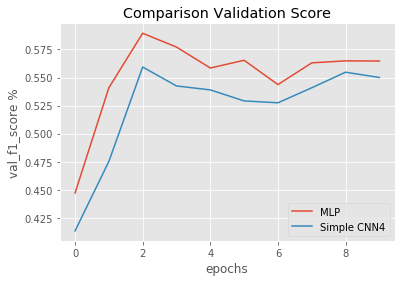

In [467]:
#Compare our best model Simple cnn4 with mlp
avgmlp_f1 = []
for i in range(10):
    avgmlp_f1.append(np.mean(mlp_his[i].history['val_f1']))

    
plt.plot(avgmlp_f1)
plt.plot(avgcnn4_f1)
plt.legend(['MLP','Simple CNN4'])
plt.ylabel('val_f1_score %')
plt.xlabel('epochs')
plt.title('Comparison Validation Score')

# ROC Curve

Micro- and macro-averages will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable since there might be class imbalance (we have many more examples of one class than of other classes).

## Reference

“Computing AUC and ROC Curve from Multi-Class Data in Scikit-Learn (Sklearn)?” Stack Overflow, 1 Jan. 1966, https://stackoverflow.com/questions/33547965/computing-auc-and-roc-curve-from-multi-class-data-in-scikit-learn-sklearn.

Contributor, Guest. “Understanding ROC Curves with Python.” Stack Abuse, Stack Abuse, 25 Feb. 2019, https://stackabuse.com/understanding-roc-curves-with-python/.

First, we just check each class' ROC performance.

In [468]:
def cycle(iterable):
    # cycle('ABCD') --> A B C D A B C D A B C D ...
    saved = []
    for element in iterable:
        yield element
        saved.append(element)
    while saved:
        for element in saved:
              yield element

Fold:1


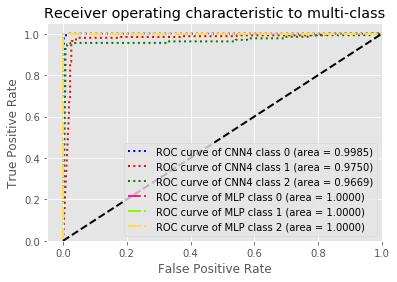

The average ROC for CNN is: 0.9801448294388679
The average ROC for MLP is: 1.0
Fold:2


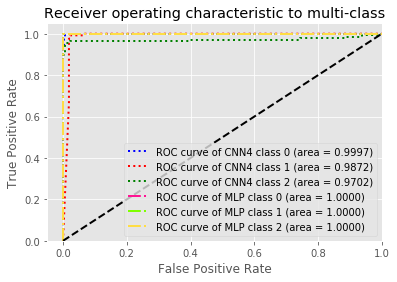

The average ROC for CNN is: 0.9857191058944421
The average ROC for MLP is: 1.0
Fold:3


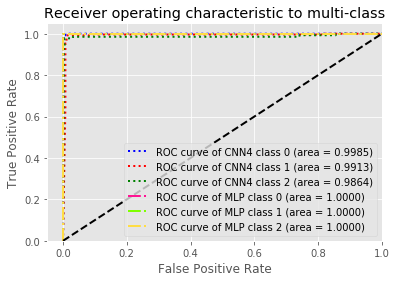

The average ROC for CNN is: 0.9920703059008318
The average ROC for MLP is: 1.0
Fold:4


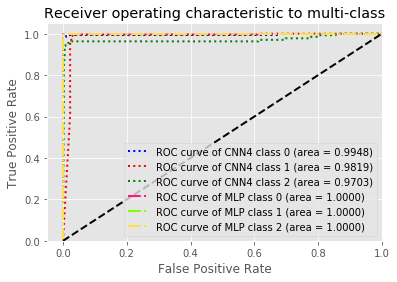

The average ROC for CNN is: 0.9823457907224981
The average ROC for MLP is: 0.9999887219488987
Fold:5


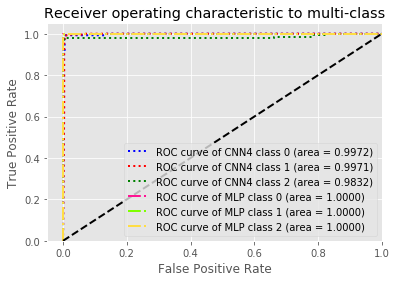

The average ROC for CNN is: 0.9924948822680997
The average ROC for MLP is: 0.9999823417530268
Fold:6


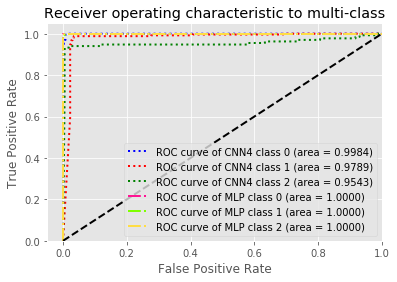

The average ROC for CNN is: 0.977205540151679
The average ROC for MLP is: 0.9999773121198352
Fold:7


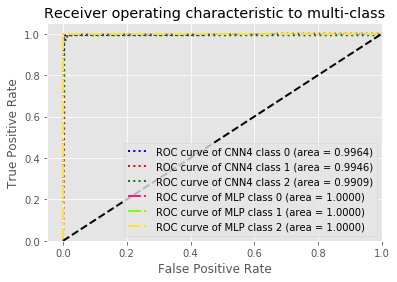

The average ROC for CNN is: 0.9939696859433363
The average ROC for MLP is: 1.0
Fold:8


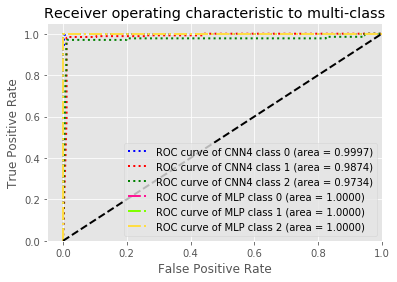

The average ROC for CNN is: 0.9868232958645407
The average ROC for MLP is: 1.0
Fold:9


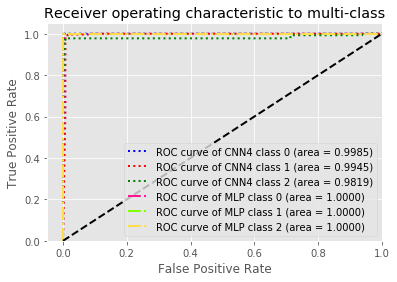

The average ROC for CNN is: 0.9916471634738239
The average ROC for MLP is: 1.0
Fold:10


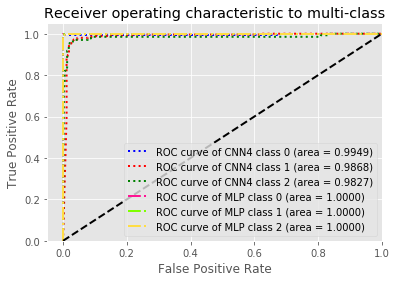

The average ROC for CNN is: 0.9881292463238648
The average ROC for MLP is: 0.9999773121198351


In [475]:
#Modified by https://stackoverflow.com/questions/33547965/computing-auc-and-roc-curve-from-multi-class-data-in-scikit-learn-sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
for j in range(10):
    print("Fold:" + str(j+1))
    y_pred = cnn4.predict(np.expand_dims(test_pca_200[j], axis=1))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    mean_roc = 0
    for i in range(CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[j][:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        mean_roc += roc_auc[i]
    mean_roc = mean_roc/CLASSES
    
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(CLASSES), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,linestyle=':',
             label='ROC curve of CNN4 class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))
    
    y_pred_mlp = mlp.predict(test_pca_200[j]) 
    fpr_mlp = dict()
    tpr_mlp = dict()
    roc_auc_mlp = dict()
    mean_roc_mlp = 0
    for i in range(CLASSES):
        fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_ohe[j][:, i], y_pred_mlp[:, i])
        roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])
        mean_roc_mlp += roc_auc_mlp[i]
    mean_roc_mlp = mean_roc_mlp/CLASSES
        
        
    colors_mlp = cycle(['deeppink', 'chartreuse', '#FFDD44'])
    for i, color in zip(range(CLASSES), colors_mlp):
        plt.plot(fpr_mlp[i], tpr_mlp[i], color=color, lw=2, linestyle='-.',
             label='ROC curve of MLP class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc_mlp[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    print("The average ROC for CNN is:" ,mean_roc)
    print("The average ROC for MLP is:" ,mean_roc_mlp)

Fold:1


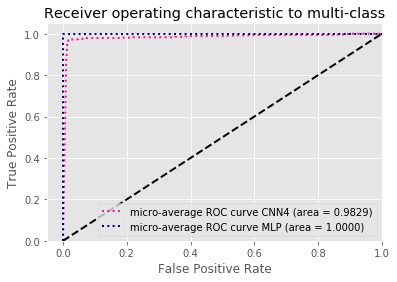

Fold:2


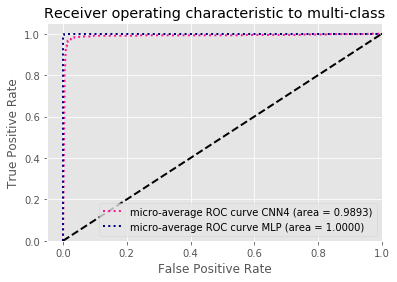

Fold:3


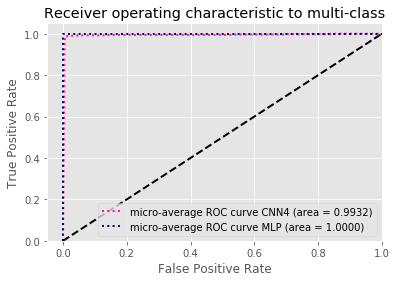

Fold:4


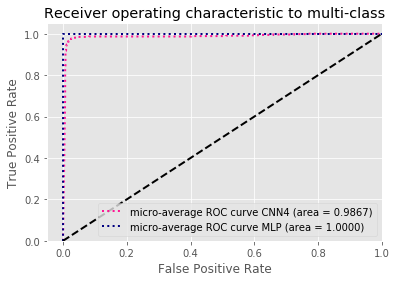

Fold:5


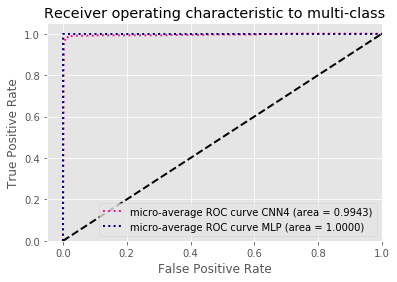

Fold:6


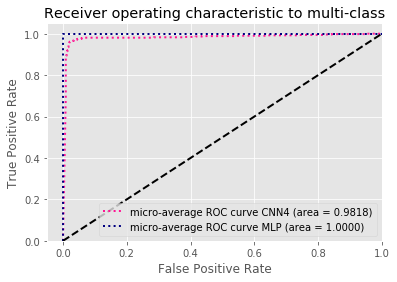

Fold:7


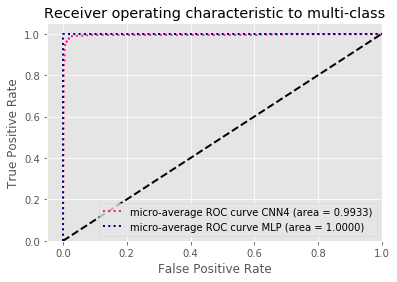

Fold:8


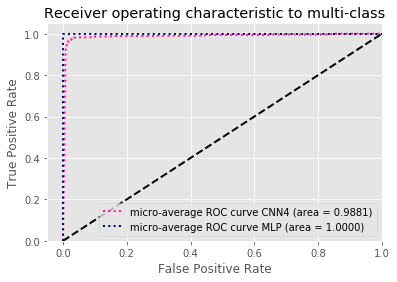

Fold:9


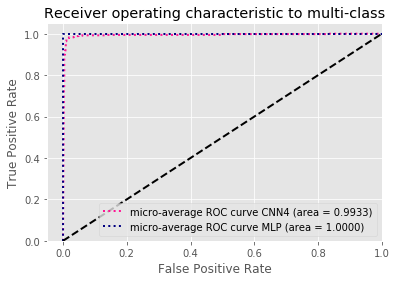

Fold:10


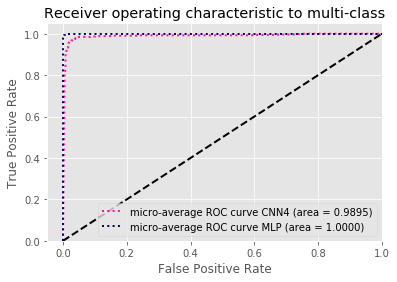

In [476]:
#Modified by https://stackoverflow.com/questions/33547965/computing-auc-and-roc-curve-from-multi-class-data-in-scikit-learn-sklearn
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from scipy import interp
for j in range(10):
    print("Fold:" + str(j+1))
    y_pred = cnn4.predict(np.expand_dims(test_pca_200[j], axis=1))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_ohe[j][:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area       
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe[j].ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    y_pred_mlp = mlp.predict(test_pca_200[j]) 
    fpr_mlp = dict()
    tpr_mlp = dict()
    roc_auc_mlp = dict()
    for i in range(CLASSES):
        fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_ohe[j][:, i], y_pred_mlp[:, i])
        roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])
        
    # Compute micro-average ROC curve and ROC area       
    fpr_mlp["micro"], tpr_mlp["micro"], _ = roc_curve(y_test_ohe[j].ravel(), y_pred_mlp.ravel())
    roc_auc_mlp["micro"] = auc(fpr_mlp["micro"], tpr_mlp["micro"])
           
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve CNN4 (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)
    plt.plot(fpr_mlp["micro"], tpr_mlp["micro"],
         label='micro-average ROC curve MLP (area = {0:0.4f})'
               ''.format(roc_auc_mlp["micro"]),
         color='navy', linestyle=':', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Conclusion

Based on the ROC result, the MLP model performs the best,but our Simple CNN4 also performs well.

# Turned in Early so no Extra Work